# Example 14 - Temporal CNN Prediction

- Predicting: Price direction
- Technology: Convolution Neural Networks(CNN)
- Asset Class: US equeities
- Difficulty: Hard
- Type: Full strategy

---

주식 가격 예측을 위한 Temporal CNN (시계열 합성곱 신경망) 모델을 사용

- 시간에 따른 데이터를 다룰 수 있도록 설계된 **합성곱 신경망(CNN)**의 변형

입력: open(시가)/high(고가)/low(저가)/close(종가)/volume(거래량) (OHLCV) 포함과 trailing stock data

출력: 향후 주가 방향(상승, 하락, 보합)을 예측

---

효과: 정확한 주가 방향 예측으로로 매수/매도/보유 전략

적절한 시점에 진입(매수)하고 이탈(매도)함으로써 투자 수익을 극대화

---
Temporal CNN 사용 이유:
- 시계열 패턴(sequential time series data) 잘 처리
- 중요한 특징을 자동으로 추출( CNNs automatically extract relevant significant features from raw OHLCV data)
- 비선형적인 주가 움직임도 잘 모델링
- 평균 회귀 전략(mean reversion)에도 활용: 주가 평균에서 크게 벗어난 종목 탐지 가능
- 노이즈에 강함: 의미 있는 패턴에 집중하고, 불필요한 잡음(노이즈)은 무시

---

왜 CNN(합성곱 신경망)이 다른 머신러닝 모델들보다 주가 예측에 더 적합할까?
- 선형 회귀는 주가 데이터에 있는 비선형적 관계를 제대로 표현하지 못함
- Decision trees or random forests는 overfitting이 자주 발생, 시간적인 패턴을 반영하지 못함
- SVM은 비선형 분류 문제를 잘 처리하지만 시간 순서가 중요한 시계열 데이터를 직접적으로 다루지 못함

→ 시간 순서를 다룰 수 있느냐, 비선형 특징을 다룰 수 있느냐

---

Model Feature: Open, High, Low, Close, Volume

Predicted Lebel: Up, Down, Stationay

Model: Temporal CNN

---
이 모델은 단일 주식의 가격 변화를 예측하려고 만들어졌음.

Temporal CNN이라는 이름은:

"Temporal" → 시간에 따라 변하는 데이터를 처리하기 때문

"CNN (Convolutional)" → 합성곱 연산으로 특징을 추출하기 때문

---

factor_names = ['open', 'high', 'low', ’close', 'volume']

class Direction：
- UP = 0
- DOWN = 1
- STATIONARY = 2

Keras deep learning library for this model

15 days of history for each of the factors OHLCV
- inputs = Input(shape=(15, 5))

입력 데이터를 합성곱(convolutional) 레이어에 넣어서, 특징(feature)을 추출

레이어를 시간에 따라 3개의 시계열 구간으로 나눔
- 장기(long-term), 중기(mid-term), 단기(short-term)
- 장기 패턴은 추세(trend)를 보여주고, 단기 패턴은 급등락 같은 변동성(volatility)을 보여주며, 중기 패턴은 둘 사이에서 중요한 전환점을 포착
short_term = Lambda(
    lambda x: tf.split(x, num_or_size_splits=3, axis=1)[2]
)(feature_extraction)

In [1]:
def _create_model(self):
    inputs = Input(shape=(self._n_steps, len(factor_names))) # 시계열 길이, feature
    # CNN 특징 추출, 30개 필터, 커널 크기 4(4일치 정보)
    feature_extraction = Conv1D(30, 4, activation='relu')(inputs)
    # 시계열을 3등분
    long_term = Lambda(lambda x: tf.split(x, num_or_size_splits=3, axis=1)[0])(feature_extraction)
    mid_term  = Lambda(lambda x: tf.split(x, num_or_size_splits=3, axis=1)[1])(feature_extraction)
    short_term= Lambda(lambda x: tf.split(x, num_or_size_splits=3, axis=1)[2])(feature_extraction)

    # 각 시계열 구간에 대해 추가적인 합성곱 레이어 적용
    long_term = Conv1D(10, 4, activation='relu')(long_term)
    mid_term  = Conv1D(10, 4, activation='relu')(mid_term)
    short_term= Conv1D(10, 4, activation='relu')(short_term)

    # 각 구간에 1x1 CNN 적용: 커널 크기 1 → 시간은 유지하고 채널만 줄임
    long_term_conv  = Conv1D(1, 1, activation='relu')(long_term)
    mid_term_conv   = Conv1D(1, 1, activation='relu')(mid_term)
    short_term_conv = Conv1D(1, 1, activation='relu')(short_term)

    #다시 합치기 + Flatten
    combined = Concatenate(axis=1)([long_term_conv, mid_term_conv, short_term_conv])
    flattened = Flatten()(combined) 
    
    # 출력층: Softmax 분류
    outputs = Dense(3, activation='softmax')(flattened)

    self._cnn = Model(inputs=inputs, outputs=outputs)
    self._cnn.compile(
        optimizer='adam',
        loss=CategoricalCrossentropy(from_logits=True)
    )

Categorical Crossentropy
다중 클래스 분류(예: 클래스가 3개: 상승, 하락, 보합)에 사용되는 손실 함수

예측된 확률과 실제 정답 라벨 간의 차이를 계산하여 학습을 진행함

예:
예측 = [0.1, 0.2, 0.7]
정답 (one-hot) = [0, 0, 1]

→ 이 두 벡터의 차이를 교차 엔트로피로 측정

One-hot encoding
정답 라벨을 벡터로 바꾸는 방식
예: 클래스 3개일 때

원래 라벨	원-핫 인코딩
0 (상승)	[1, 0, 0]
1 (보합)	[0, 1, 0]
2 (하락)	[0, 0, 1]

---

### 종목 선택

매주 초, QQQ ETF를 구성하는 종목 중에서 비중(weight)이 가장 높은 3개 종목을 선택

--- 

- 모델 학습 시점: 매주 첫 거래일 오전 9시
- 리밸런싱 시점: 시장 개장 후 2분 뒤
- 비중 설정 기준: 주가 방향 예측 결과 + the confidence level of the prediction(확률)
- 비중 제한 조건: 전체 포트폴리오의 절댓값 합 ≤ 1

---

- initialize(): 매주 트레이딩 스케줄을 설정
- self.schedule.on(...): 매주 특정 시간(시장 개장 2분 후)에 _trade() 함수 실행
- _trade(): 각 종목에 대해 예측 → 비중 설정 → 포트폴리오 리밸런싱


In [ ]:
def initialize(self):
    # 매주 첫 거래일 시장 개장 2분 후에 트레이드 실행
    self.schedule.on(
        date_rule,
        self.time_rules.after_market_open(etf, 2),
        self._trade
    )

def _trade(self):
    # 종목별 예측 및 confidence 기반 가중치 계산
    weight_by_symbol = {}

    for symbol in self.universe.selected:
        security = self.securities[symbol]
        symbol_df = security.history.tail(15)  # 최근 15일 OHLCV
        
        prediction, confidence = security.cnn.predict(symbol_df)

        # 보합이 아니고, confidence가 유효하며 0.55 초과일 때만 거래 대상
        if (
            prediction != Direction.STATIONARY and
            not math.isnan(confidence) and
            confidence > 0.55
        ):
            factor = -1 if prediction == Direction.DOWN else 1
            weight_by_symbol[security.symbol] = factor * confidence

            # 시각화 로그
            self.plot("Confidence", str(security.symbol.id), confidence)

    # 전체 비중의 절댓값 합 계산
    weight_sum = sum(abs(w) for w in weight_by_symbol.values())
    
    # 비중 총합이 1을 초과하지 않도록 조정
    weight_factor = 1 if weight_sum <= 1 else 1 / weight_sum

    # 리밸런싱 대상 구성
    portfolio_targets = [
        PortfolioTarget(symbol, weight * weight_factor)
        for symbol, weight in weight_by_symbol.items()
    ]

    # 포트폴리오 리밸런싱 실행
    self.set_holdings(portfolio_targets, True)


순서
1. trade 메서드는 해당 종목의 최근 15일치 OHLCV 주식 데이터를 불러옴
2. 데이터를 모델에 넣어 예측(prediction) 함수를 호출
3. 예측 결과가 보합(STATIONARY)이 아니고, confidence(확신도)가 55%보다 높으면
상승 (UP): +confidence, 하락 (DOWN): –confidence
로 비중을 설정
4. 계산된 종목별 비중을 정규화(normalize): 전체 비중의 절댓값 합이 1이 되도록 비례 조정
   (각 종목의 비중이 confidence에 비례하도록 하면서도 전체 투자 금액이 100%를 넘지 않도록 제한하기 위한 처리)

---
주식 분할을 자동으로 감지하고 적절히 대응하기위해?

In [ ]:
def on_splits(self, splits):
    for symbol, split in splits.items():
        if split.type == SplitType.SPLIT_OCCURRED:
            self._initialize_security(self.securities[symbol])

Training sample 수가 많을수록 Sharpe ratio가 증가하는 경향이 있다.

→ 학습 데이터가 많을수록 전략 성능이 좋아짐

최소값	300일 → 1년치 거래일보다 약간 많음 (실제 약 252일/년)

최대값	700일 → 너무 느려지지 않는 한도 내에서 많은 데이터

step	100일 간격 → 300, 400, 500, 600, 700 총 5가지 실험


대부분의 파라미터 조합은 수익성이 낮다 (unprofitable).

최소값	2개 → 항상 최소 1개 이상 종목을 보유하게 하기 위해 (1개만 있으면 '보합'일 경우 투자 안 함)

최대값	10개 → 10개 넘으면 백테스트가 1시간 이상 걸려 실험 속도가 느려짐

step	2씩 증가 → 2, 4, 6, 8, 10 (총 5가지 실험)

→ 전체 실험 중 일부 설정만 좋은 성능을 보임


사용된 파라미터 조합 (실제 실험에 사용한 값)

training_samples = 500

universe_size = 3

### Implementation Insight

 UP/DOWN(상승/하락) 방향을 예측하는 머신러닝 모델을 훈련시키기 위한 전처리 및 모델 생성 과정을 설명

 

In [51]:
# =============================================================================
# 셀 1: PyTorch 설치 및 라이브러리 임포트
# =============================================================================

"""
PyTorch 설치 (TensorFlow 대신):
pip install torch torchvision torchaudio

PyTorch는 TensorFlow보다 설치가 안정적이며, 
동일한 Temporal CNN 기능을 구현할 수 있습니다.
"""
import numpy as np
import pandas as pd
import yfinance as yf

# PyTorch 임포트
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import Dataset, DataLoader
    import torch.nn.functional as F
    
    print("✅ PyTorch 임포트 성공!")
    print(f"PyTorch 버전: {torch.__version__}")
    
    # CUDA 확인
    if torch.cuda.is_available():
        print(f"🚀 GPU 사용 가능! ({torch.cuda.get_device_name(0)})")
        device = torch.device('cuda')
    else:
        print("💻 CPU 모드로 실행됩니다.")
        device = torch.device('cpu')
        
    PYTORCH_AVAILABLE = True
    
except ImportError as e:
    print("❌ PyTorch 임포트 실패!")
    print(f"다음 명령어로 설치하세요: pip install torch torchvision torchaudio")
    PYTORCH_AVAILABLE = False
    device = None

# 다른 필수 라이브러리
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 8)

if PYTORCH_AVAILABLE:
    print("🎉 모든 라이브러리 임포트 완료!")

✅ PyTorch 임포트 성공!
PyTorch 버전: 2.7.1+cpu
💻 CPU 모드로 실행됩니다.
🎉 모든 라이브러리 임포트 완료!


In [52]:
# =============================================================================
# 셀 2: 클래스 및 상수 정의
# =============================================================================

class Direction:
    """주가 방향 정의"""
    UP = 0
    DOWN = 1
    STATIONARY = 2
    
    @classmethod
    def get_name(cls, value):
        names = {0: 'UP', 1: 'DOWN', 2: 'STATIONARY'}
        return names.get(value, 'UNKNOWN')

# 전역 설정
FACTOR_NAMES = ['Open', 'High', 'Low', 'Close', 'Volume']
N_STEPS = 15  # 15일간의 히스토리 사용
CONFIDENCE_THRESHOLD = 0.55  # 거래 임계값
INITIAL_CAPITAL = 10_000_000  # 초기 자본 1천만원

print("✅ 클래스 및 상수 정의 완료!")
print(f"사용할 특징: {FACTOR_NAMES}")
print(f"시계열 길이: {N_STEPS}일")
print(f"신뢰도 임계값: {CONFIDENCE_THRESHOLD}")

✅ 클래스 및 상수 정의 완료!
사용할 특징: ['Open', 'High', 'Low', 'Close', 'Volume']
시계열 길이: 15일
신뢰도 임계값: 0.55


In [53]:
# =============================================================================
# 셀 3: 데이터 다운로드
# =============================================================================

def download_samsung_data():
    """삼성전자 주식 데이터 다운로드"""
    print("📊 삼성전자 주식 데이터 다운로드 중...")
    
    try:
        # 삼성전자 종목코드: 005930.KS
        ticker = "005930.KS"
        raw_data = yf.download(ticker, period="3y", interval="1d")
        
        print(f"📊 원본 데이터 구조 확인:")
        print(f"  컬럼 타입: {type(raw_data.columns)}")
        print(f"  컬럼: {raw_data.columns.tolist()}")
        print(f"  데이터 형태: {raw_data.shape}")
        
        # 데이터 구조에 따른 처리
        if isinstance(raw_data.columns, pd.MultiIndex):
            print("  MultiIndex 컬럼 감지 - 레벨 제거 중...")
            # 첫 번째 레벨만 사용
            raw_data.columns = [col[0] if isinstance(col, tuple) else col for col in raw_data.columns]
        
        # 컬럼명 표준화
        column_mapping = {
            'Adj Close': 'Adj_Close',
            'Adj_Close': 'Adj_Close'
        }
        
        raw_data = raw_data.rename(columns=column_mapping)
        
        # 필요한 컬럼만 선택
        required_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        available_columns = [col for col in required_columns if col in raw_data.columns]
        
        print(f"  사용 가능한 컬럼: {available_columns}")
        
        if len(available_columns) < 5:
            print(f"❌ 필요한 컬럼이 부족합니다: {available_columns}")
            return None
        
        # 최종 데이터 생성
        samsung = raw_data[available_columns].copy()
        samsung = samsung.dropna()
        
        print(f"✅ 데이터 다운로드 완료!")
        print(f"📅 기간: {samsung.index[0].strftime('%Y-%m-%d')} ~ {samsung.index[-1].strftime('%Y-%m-%d')}")
        print(f"📈 총 데이터 포인트: {len(samsung):,}개")
        
        return samsung
        
    except Exception as e:
        print(f"❌ 데이터 다운로드 실패: {e}")
        print("🔄 대안 방법으로 재시도...")
        
        try:
            # 대안 방법: 개별 컬럼 접근
            raw_data = yf.download(ticker, period="3y", interval="1d")
            
            # 새로운 DataFrame 생성
            samsung = pd.DataFrame(index=raw_data.index)
            
            # 각 컬럼을 개별적으로 추가
            for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
                if col in raw_data.columns:
                    samsung[col] = raw_data[col]
                elif (col, ticker) in raw_data.columns:
                    samsung[col] = raw_data[(col, ticker)]
                else:
                    # 컬럼을 찾을 수 없는 경우
                    for orig_col in raw_data.columns:
                        if col.lower() in str(orig_col).lower():
                            samsung[col] = raw_data[orig_col]
                            break
            
            samsung = samsung.dropna()
            
            if len(samsung) > 0 and len(samsung.columns) >= 5:
                print(f"✅ 대안 방법으로 데이터 다운로드 완료!")
                print(f"📅 기간: {samsung.index[0].strftime('%Y-%m-%d')} ~ {samsung.index[-1].strftime('%Y-%m-%d')}")
                print(f"📈 총 데이터 포인트: {len(samsung):,}개")
                return samsung
            else:
                print("❌ 대안 방법도 실패했습니다.")
                return None
                
        except Exception as e2:
            print(f"❌ 대안 방법도 실패: {e2}")
            
            # 마지막 대안: 샘플 데이터 생성
            print("🔄 샘플 데이터를 생성합니다...")
            return create_sample_data()

def create_sample_data():
    """샘플 데이터 생성 (다운로드 실패시 대안)"""
    print("📊 샘플 데이터 생성 중...")
    
    # 3년치 거래일 생성 (약 780일)
    dates = pd.date_range(start='2022-01-01', end='2024-12-31', freq='B')  # 비즈니스 데이 only
    
    np.random.seed(42)  # 재현 가능한 결과
    
    # 초기 가격
    initial_price = 60000
    
    # 랜덤 워크로 주가 생성
    returns = np.random.normal(0.0005, 0.02, len(dates))  # 평균 0.05%, 변동성 2%
    prices = [initial_price]
    
    for ret in returns[1:]:
        new_price = prices[-1] * (1 + ret)
        prices.append(max(new_price, 1000))  # 최소 1000원
    
    # OHLCV 데이터 생성
    data = []
    for i, (date, price) in enumerate(zip(dates, prices)):
        # 일중 변동성 추가
        daily_vol = np.random.uniform(0.005, 0.03)
        
        # High, Low 생성
        high = price * (1 + daily_vol * np.random.uniform(0.3, 1.0))
        low = price * (1 - daily_vol * np.random.uniform(0.3, 1.0))
        
        # Open 생성 (전일 종가 기준)
        if i == 0:
            open_price = price
        else:
            open_price = prices[i-1] * (1 + np.random.normal(0, 0.01))
        
        # Volume 생성
        volume = int(np.random.lognormal(15, 0.5))  # 로그정규분포
        
        data.append({
            'Open': open_price,
            'High': max(high, open_price, price),
            'Low': min(low, open_price, price),
            'Close': price,
            'Volume': volume
        })
    
    samsung = pd.DataFrame(data, index=dates)
    
    print(f"✅ 샘플 데이터 생성 완료!")
    print(f"📅 기간: {samsung.index[0].strftime('%Y-%m-%d')} ~ {samsung.index[-1].strftime('%Y-%m-%d')}")
    print(f"📈 총 데이터 포인트: {len(samsung):,}개")
    print("⚠️ 주의: 실제 삼성전자 데이터가 아닌 시뮬레이션 데이터입니다.")
    
    return samsung

# 데이터 다운로드
samsung_data = download_samsung_data()

if samsung_data is not None:
    print("\n📊 데이터 미리보기:")
    print(samsung_data.head())
    print(f"\n📊 데이터 형태: {samsung_data.shape}")
    print(f"📊 기간: {(samsung_data.index[-1] - samsung_data.index[0]).days}일")


📊 삼성전자 주식 데이터 다운로드 중...


[*********************100%***********************]  1 of 1 completed

📊 원본 데이터 구조 확인:
  컬럼 타입: <class 'pandas.core.indexes.multi.MultiIndex'>
  컬럼: [('Close', '005930.KS'), ('High', '005930.KS'), ('Low', '005930.KS'), ('Open', '005930.KS'), ('Volume', '005930.KS')]
  데이터 형태: (735, 5)
  MultiIndex 컬럼 감지 - 레벨 제거 중...
  사용 가능한 컬럼: ['Open', 'High', 'Low', 'Close', 'Volume']
✅ 데이터 다운로드 완료!
📅 기간: 2022-07-25 ~ 2025-07-25
📈 총 데이터 포인트: 735개

📊 데이터 미리보기:
                    Open          High           Low         Close    Volume
Date                                                                        
2022-07-25  57292.102502  58232.859522  57198.026800  57480.253906   9193681
2022-07-26  57198.018031  58232.850594  57198.018031  58044.699219   6597211
2022-07-27  57668.398886  58232.853035  57574.323195  58138.777344   7320997
2022-07-28  58609.154319  58891.381386  57950.624495  58232.851562  10745302
2022-07-29  58703.229540  58891.380917  57668.396968  57762.472656  15093120

📊 데이터 형태: (735, 5)
📊 기간: 1096일


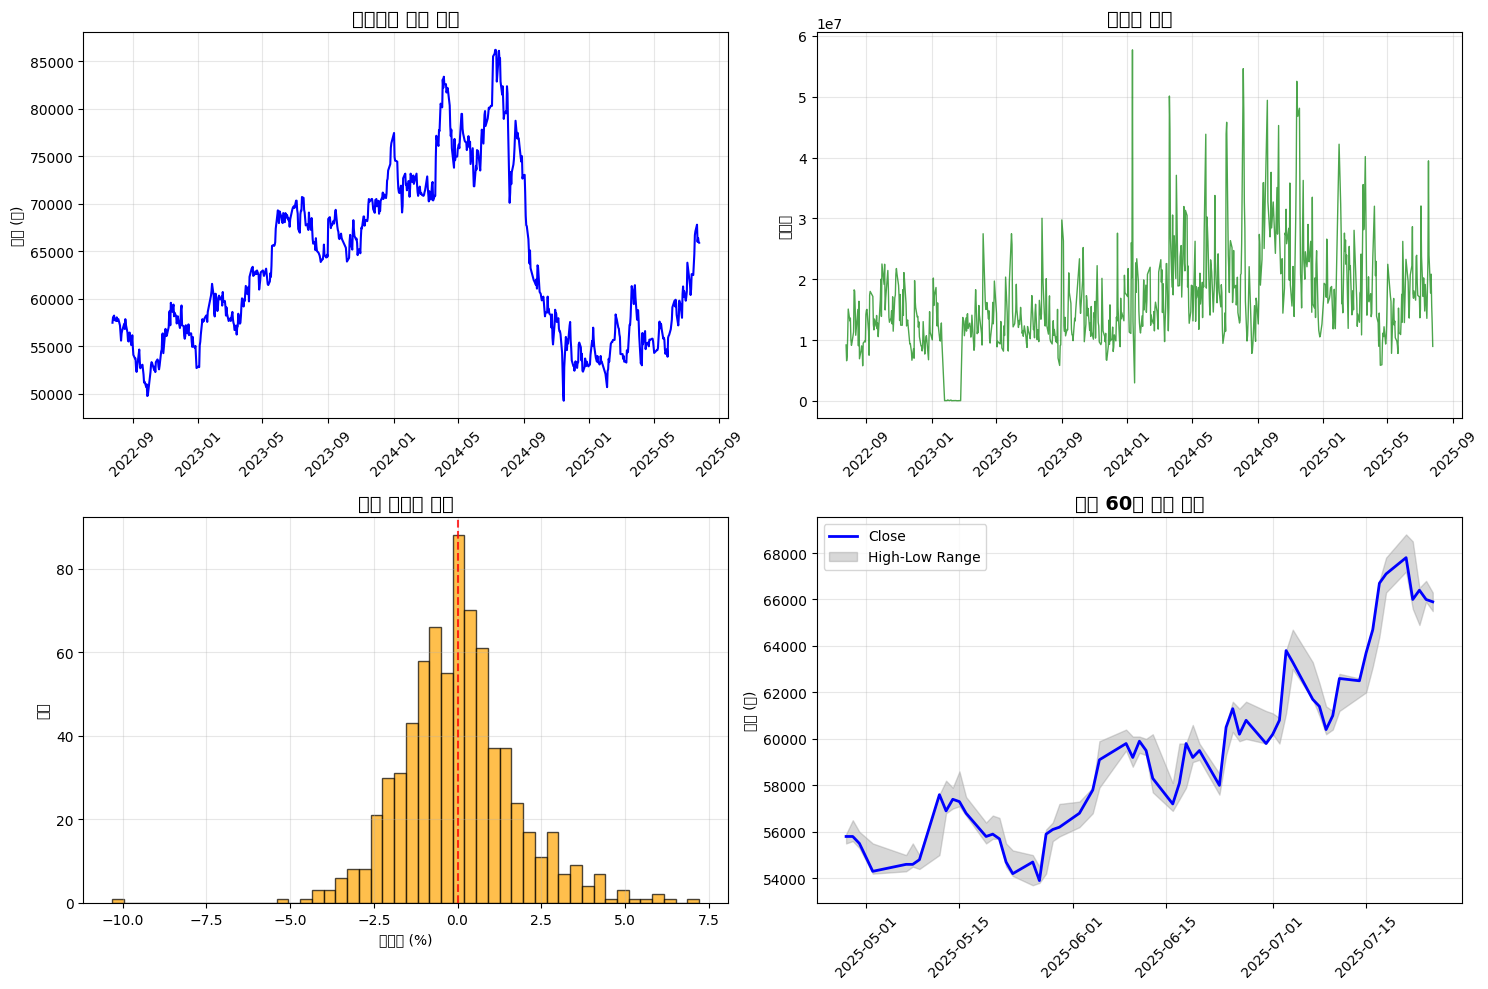

📈 주식 기본 통계:
  평균 일일 수익률: 0.033%
  일일 변동성: 1.727%
  연간 변동성: 27.41%
  최대 일일 상승: 7.21%
  최대 일일 하락: -10.30%
  현재 주가: 65,900원


In [54]:
# =============================================================================
# 셀 4: 데이터 시각화
# =============================================================================

def plot_stock_analysis(data):
    """주식 데이터 분석 시각화"""
    # 데이터 구조 확인 및 정리
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.droplevel(1)
    
    # 필요한 컬럼이 있는지 확인
    required_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    available_cols = [col for col in required_cols if col in data.columns]
    
    if len(available_cols) < 4:
        print(f"❌ 필요한 컬럼이 부족합니다. 사용 가능: {available_cols}")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 주가 차트
    axes[0,0].plot(data.index, data['Close'], linewidth=1.5, color='blue')
    axes[0,0].set_title('삼성전자 주가 추이', fontsize=14, fontweight='bold')
    axes[0,0].set_ylabel('주가 (원)')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # 거래량 차트
    if 'Volume' in data.columns:
        axes[0,1].plot(data.index, data['Volume'], linewidth=1, color='green', alpha=0.7)
        axes[0,1].set_title('거래량 추이', fontsize=14, fontweight='bold')
        axes[0,1].set_ylabel('거래량')
        axes[0,1].grid(True, alpha=0.3)
        axes[0,1].tick_params(axis='x', rotation=45)
    
    # 일일 수익률 분포
    daily_returns = data['Close'].pct_change().dropna()
    axes[1,0].hist(daily_returns * 100, bins=50, alpha=0.7, color='orange', edgecolor='black')
    axes[1,0].set_title('일일 수익률 분포', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('수익률 (%)')
    axes[1,0].set_ylabel('빈도')
    axes[1,0].axvline(x=0, color='red', linestyle='--', alpha=0.8)
    axes[1,0].grid(True, alpha=0.3)
    
    # OHLC 캔들스틱 스타일 (수정된 부분)
    recent_data = data.tail(60)  # 최근 60일
    axes[1,1].plot(recent_data.index, recent_data['Close'], linewidth=2, color='blue', label='Close')
    
    # High-Low 범위 (1차원 배열로 변환)
    if 'High' in data.columns and 'Low' in data.columns:
        high_values = recent_data['High'].values.flatten()
        low_values = recent_data['Low'].values.flatten()
        axes[1,1].fill_between(recent_data.index, low_values, high_values, 
                              alpha=0.3, color='gray', label='High-Low Range')
    
    axes[1,1].set_title('최근 60일 주가 상세', fontsize=14, fontweight='bold')
    axes[1,1].set_ylabel('주가 (원)')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # 기본 통계 출력
    print("📈 주식 기본 통계:")
    print(f"  평균 일일 수익률: {daily_returns.mean()*100:.3f}%")
    print(f"  일일 변동성: {daily_returns.std()*100:.3f}%")
    print(f"  연간 변동성: {daily_returns.std()*np.sqrt(252)*100:.2f}%")
    print(f"  최대 일일 상승: {daily_returns.max()*100:.2f}%")
    print(f"  최대 일일 하락: {daily_returns.min()*100:.2f}%")
    print(f"  현재 주가: {data['Close'].iloc[-1]:,.0f}원")

# 데이터 시각화
if samsung_data is not None:
    plot_stock_analysis(samsung_data)

In [35]:
# =============================================================================
# 셀 5: PyTorch Dataset 클래스 정의
# =============================================================================

if PYTORCH_AVAILABLE:
    class StockDataset(Dataset):
        """주식 데이터를 위한 PyTorch Dataset"""
        def __init__(self, X, y):
            self.X = torch.FloatTensor(X)
            self.y = torch.LongTensor(y)
        
        def __len__(self):
            return len(self.X)
        
        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]

    print("✅ StockDataset 클래스 정의 완료!")

✅ StockDataset 클래스 정의 완료!


In [ ]:
# =============================================================================
# 셀 7: 모델 래퍼 클래스 정의
# =============================================================================

if PYTORCH_AVAILABLE:
    class TemporalCNNWrapper:
        """PyTorch 모델을 위한 래퍼 클래스"""
        
        def __init__(self, n_steps=15):
            self.n_steps = n_steps
            self.factor_names = FACTOR_NAMES
            self.scaler = StandardScaler()
            self.model = None
            self.device = device
            self.history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
            
        def prepare_data(self, df, prediction_days=1, price_change_threshold=0.01):
            """데이터 전처리 및 라벨 생성"""
            print("🔄 데이터 전처리 중...")
            
            # OHLCV 데이터 준비
            features = df[self.factor_names].values
            
            # 정규화
            features_scaled = self.scaler.fit_transform(features)
            
            # 시계열 데이터셋 생성
            X, y = [], []
            for i in range(self.n_steps, len(features_scaled) - prediction_days):
                X.append(features_scaled[i-self.n_steps:i])
                
                # 라벨 생성
                current_price = df.iloc[i]['Close']
                future_price = df.iloc[i + prediction_days]['Close']
                
                price_change = (future_price - current_price) / current_price
                
                if price_change > price_change_threshold:
                    label = Direction.UP
                elif price_change < -price_change_threshold:
                    label = Direction.DOWN
                else:
                    label = Direction.STATIONARY
                
                y.append(label)
            
            X, y = np.array(X), np.array(y)
            
            print(f"✅ 데이터 전처리 완료!")
            print(f"📊 데이터 형태: X={X.shape}, y={y.shape}")
            
            # 라벨 분포 출력
            unique, counts = np.unique(y, return_counts=True)
            for label, count in zip(unique, counts):
                print(f"  {Direction.get_name(label)}: {count:,}개 ({count/len(y)*100:.1f}%)")
            
            return X, y
        
        def train(self, X_train, y_train, X_val=None, y_val=None, epochs=100, batch_size=32, learning_rate=0.001):
            """모델 훈련"""
            print("🚀 PyTorch Temporal CNN 훈련 시작...")
            
            # 모델 생성
            self.model = TemporalCNN(n_steps=self.n_steps, n_features=len(self.factor_names))
            self.model.to(self.device)
            
            # 옵티마이저 및 손실 함수
            optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-5)
            criterion = nn.CrossEntropyLoss()
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
            
            # 데이터 검증 분할
            if X_val is None:
                val_size = int(len(X_train) * 0.2)
                X_val, y_val = X_train[-val_size:], y_train[-val_size:]
                X_train, y_train = X_train[:-val_size], y_train[:-val_size]
            
            # 데이터 로더 생성
            train_dataset = StockDataset(X_train, y_train)
            val_dataset = StockDataset(X_val, y_val)
            
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
            
            # 훈련 루프
            best_val_loss = float('inf')
            patience_counter = 0
            
            for epoch in range(epochs):
                # 훈련
                self.model.train()
                train_loss = 0.0
                train_correct = 0
                train_total = 0
                
                for batch_X, batch_y in train_loader:
                    batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                    
                    optimizer.zero_grad()
                    outputs = self.model(batch_X)
                    loss = criterion(outputs, batch_y)
                    loss.backward()
                    optimizer.step()
                    
                    train_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    train_total += batch_y.size(0)
                    train_correct += (predicted == batch_y).sum().item()
                
                # 검증
                self.model.eval()
                val_loss = 0.0
                val_correct = 0
                val_total = 0
                
                with torch.no_grad():
                    for batch_X, batch_y in val_loader:
                        batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                        outputs = self.model(batch_X)
                        loss = criterion(outputs, batch_y)
                        
                        val_loss += loss.item()
                        _, predicted = torch.max(outputs.data, 1)
                        val_total += batch_y.size(0)
                        val_correct += (predicted == batch_y).sum().item()
                
                # 평균 계산
                avg_train_loss = train_loss / len(train_loader)
                avg_val_loss = val_loss / len(val_loader)
                train_acc = train_correct / train_total
                val_acc = val_correct / val_total
                
                # 기록
                self.history['train_loss'].append(avg_train_loss)
                self.history['val_loss'].append(avg_val_loss)
                self.history['train_acc'].append(train_acc)
                self.history['val_acc'].append(val_acc)
                
                # 스케줄러 업데이트
                scheduler.step(avg_val_loss)
                
                # 얼리 스탑핑
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    patience_counter = 0
                    # 최고 모델 저장 (안전한 방식)
                    try:
                        torch.save(self.model.state_dict(), 'best_model.pth', _use_new_zipfile_serialization=False)
                    except:
                        # 파일 저장 실패시 메모리에만 저장
                        self.best_model_state = self.model.state_dict().copy()
                else:
                    patience_counter += 1
                
                # 진행률 출력
                if epoch % 10 == 0 or epoch == epochs - 1:
                    print(f"Epoch {epoch+1}/{epochs}: "
                          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
                
                # 얼리 스탑핑 체크
                if patience_counter >= 15:
                    print(f"얼리 스탑핑: {patience_counter}번 연속 개선 없음")
                    break
            
            # 최고 모델 로드
            try:
                self.model.load_state_dict(torch.load('best_model.pth', map_location=self.device))
            except:
                # 파일 로드 실패시 메모리에서 로드
                if hasattr(self, 'best_model_state'):
                    self.model.load_state_dict(self.best_model_state)
                    print("⚠️ 파일에서 로드 실패, 메모리에서 최고 모델 복원")
            
            print("✅ 모델 훈련 완료!")
            
            return self.history
        
        def plot_training_history(self):
            """훈련 과정 시각화"""
            if not self.history['train_loss']:
                print("❌ 훈련 기록이 없습니다.")
                return
            
            fig, axes = plt.subplots(1, 2, figsize=(15, 5))
            
            # 손실 함수
            axes[0].plot(self.history['train_loss'], label='Training Loss', linewidth=2)
            axes[0].plot(self.history['val_loss'], label='Validation Loss', linewidth=2)
            axes[0].set_title('모델 손실 함수', fontsize=14, fontweight='bold')
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Loss')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)
            
            # 정확도
            axes[1].plot(self.history['train_acc'], label='Training Accuracy', linewidth=2)
            axes[1].plot(self.history['val_acc'], label='Validation Accuracy', linewidth=2)
            axes[1].set_title('모델 정확도', fontsize=14, fontweight='bold')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('Accuracy')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
        
        def predict(self, X):
            """예측 수행"""
            if self.model is None:
                print("❌ 모델이 훈련되지 않았습니다.")
                return None, None
                
            self.model.eval()
            
            # 입력 데이터 형태 확인 및 조정
            if isinstance(X, np.ndarray):
                if X.ndim == 2:  # (n_steps, n_features) -> (1, n_steps, n_features)
                    X = X.reshape(1, X.shape[0], X.shape[1])
                X_tensor = torch.FloatTensor(X).to(self.device)
            else:
                X_tensor = X.to(self.device)
            
            with torch.no_grad():
                outputs = self.model(X_tensor)
                probabilities = F.softmax(outputs, dim=1)
                predicted_classes = torch.argmax(probabilities, dim=1)
                confidences = torch.max(probabilities, dim=1)[0]
            
            return predicted_classes.cpu().numpy(), confidences.cpu().numpy()
    
    print("✅ TemporalCNNWrapper 클래스 정의 완료!")


✅ TemporalCNNWrapper 클래스 정의 완료!


In [ ]:
# =============================================================================
# 셀 7: 모델 래퍼 클래스 정의
# =============================================================================

if PYTORCH_AVAILABLE:
    class TemporalCNNWrapper:
        """PyTorch 모델을 위한 래퍼 클래스"""
        
        def __init__(self, n_steps=15):
            self.n_steps = n_steps
            self.factor_names = FACTOR_NAMES
            self.scaler = StandardScaler()
            self.model = None
            self.device = device
            self.history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
            
        def prepare_data(self, df, prediction_days=1, price_change_threshold=0.01):
            """데이터 전처리 및 라벨 생성"""
            print("🔄 데이터 전처리 중...")
            
            # OHLCV 데이터 준비
            features = df[self.factor_names].values
            
            # 정규화
            features_scaled = self.scaler.fit_transform(features)
            
            # 시계열 데이터셋 생성
            X, y = [], []
            for i in range(self.n_steps, len(features_scaled) - prediction_days):
                X.append(features_scaled[i-self.n_steps:i])
                
                # 라벨 생성
                current_price = df.iloc[i]['Close']
                future_price = df.iloc[i + prediction_days]['Close']
                
                price_change = (future_price - current_price) / current_price
                
                if price_change > price_change_threshold:
                    label = Direction.UP
                elif price_change < -price_change_threshold:
                    label = Direction.DOWN
                else:
                    label = Direction.STATIONARY
                
                y.append(label)
            
            X, y = np.array(X), np.array(y)
            
            print(f"✅ 데이터 전처리 완료!")
            print(f"📊 데이터 형태: X={X.shape}, y={y.shape}")
            
            # 라벨 분포 출력
            unique, counts = np.unique(y, return_counts=True)
            for label, count in zip(unique, counts):
                print(f"  {Direction.get_name(label)}: {count:,}개 ({count/len(y)*100:.1f}%)")
            
            return X, y
        
        def train(self, X_train, y_train, X_val=None, y_val=None, epochs=100, batch_size=32, learning_rate=0.001):
            """모델 훈련"""
            print("🚀 PyTorch Temporal CNN 훈련 시작...")
            
            # 모델 생성
            self.model = TemporalCNN(n_steps=self.n_steps, n_features=len(self.factor_names))
            self.model.to(self.device)
            
            # 옵티마이저 및 손실 함수
            optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-5)
            criterion = nn.CrossEntropyLoss()
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
            
            # 데이터 검증 분할
            if X_val is None:
                val_size = int(len(X_train) * 0.2)
                X_val, y_val = X_train[-val_size:], y_train[-val_size:]
                X_train, y_train = X_train[:-val_size], y_train[:-val_size]
            
            # 데이터 로더 생성
            train_dataset = StockDataset(X_train, y_train)
            val_dataset = StockDataset(X_val, y_val)
            
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
            
            # 훈련 루프
            best_val_loss = float('inf')
            patience_counter = 0
            
            for epoch in range(epochs):
                # 훈련
                self.model.train()
                train_loss = 0.0
                train_correct = 0
                train_total = 0
                
                for batch_X, batch_y in train_loader:
                    batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                    
                    optimizer.zero_grad()
                    outputs = self.model(batch_X)
                    loss = criterion(outputs, batch_y)
                    loss.backward()
                    optimizer.step()
                    
                    train_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    train_total += batch_y.size(0)
                    train_correct += (predicted == batch_y).sum().item()
                
                # 검증
                self.model.eval()
                val_loss = 0.0
                val_correct = 0
                val_total = 0
                
                with torch.no_grad():
                    for batch_X, batch_y in val_loader:
                        batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                        outputs = self.model(batch_X)
                        loss = criterion(outputs, batch_y)
                        
                        val_loss += loss.item()
                        _, predicted = torch.max(outputs.data, 1)
                        val_total += batch_y.size(0)
                        val_correct += (predicted == batch_y).sum().item()
                
                # 평균 계산
                avg_train_loss = train_loss / len(train_loader)
                avg_val_loss = val_loss / len(val_loader)
                train_acc = train_correct / train_total
                val_acc = val_correct / val_total
                
                # 기록
                self.history['train_loss'].append(avg_train_loss)
                self.history['val_loss'].append(avg_val_loss)
                self.history['train_acc'].append(train_acc)
                self.history['val_acc'].append(val_acc)
                
                # 스케줄러 업데이트
                scheduler.step(avg_val_loss)
                
                # 얼리 스탑핑
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    patience_counter = 0
                    # 최고 모델 저장 (안전한 방식)
                    try:
                        torch.save(self.model.state_dict(), 'best_model.pth', _use_new_zipfile_serialization=False)
                    except:
                        # 파일 저장 실패시 메모리에만 저장
                        self.best_model_state = self.model.state_dict().copy()
                else:
                    patience_counter += 1
                
                # 진행률 출력
                if epoch % 10 == 0 or epoch == epochs - 1:
                    print(f"Epoch {epoch+1}/{epochs}: "
                          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
                
                # 얼리 스탑핑 체크
                if patience_counter >= 15:
                    print(f"얼리 스탑핑: {patience_counter}번 연속 개선 없음")
                    break
            
            # 최고 모델 로드
            try:
                self.model.load_state_dict(torch.load('best_model.pth', map_location=self.device))
            except:
                # 파일 로드 실패시 메모리에서 로드
                if hasattr(self, 'best_model_state'):
                    self.model.load_state_dict(self.best_model_state)
                    print("⚠️ 파일에서 로드 실패, 메모리에서 최고 모델 복원")
            
            print("✅ 모델 훈련 완료!")
            
            return self.history
        
        def plot_training_history(self):
            """훈련 과정 시각화"""
            if not self.history['train_loss']:
                print("❌ 훈련 기록이 없습니다.")
                return
            
            fig, axes = plt.subplots(1, 2, figsize=(15, 5))
            
            # 손실 함수
            axes[0].plot(self.history['train_loss'], label='Training Loss', linewidth=2)
            axes[0].plot(self.history['val_loss'], label='Validation Loss', linewidth=2)
            axes[0].set_title('모델 손실 함수', fontsize=14, fontweight='bold')
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Loss')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)
            
            # 정확도
            axes[1].plot(self.history['train_acc'], label='Training Accuracy', linewidth=2)
            axes[1].plot(self.history['val_acc'], label='Validation Accuracy', linewidth=2)
            axes[1].set_title('모델 정확도', fontsize=14, fontweight='bold')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('Accuracy')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
        
        def predict(self, X):
            """예측 수행"""
            if self.model is None:
                print("❌ 모델이 훈련되지 않았습니다.")
                return None, None
                
            self.model.eval()
            
            # 입력 데이터 형태 확인 및 조정
            if isinstance(X, np.ndarray):
                if X.ndim == 2:  # (n_steps, n_features) -> (1, n_steps, n_features)
                    X = X.reshape(1, X.shape[0], X.shape[1])
                X_tensor = torch.FloatTensor(X).to(self.device)
            else:
                X_tensor = X.to(self.device)
            
            with torch.no_grad():
                outputs = self.model(X_tensor)
                probabilities = F.softmax(outputs, dim=1)
                predicted_classes = torch.argmax(probabilities, dim=1)
                confidences = torch.max(probabilities, dim=1)[0]
            
            return predicted_classes.cpu().numpy(), confidences.cpu().numpy()
    
    print("✅ TemporalCNNWrapper 클래스 정의 완료!")


✅ TemporalCNNWrapper 클래스 정의 완료!


In [ ]:
# =============================================================================
# 셀 7: 모델 래퍼 클래스 정의
# =============================================================================

if PYTORCH_AVAILABLE:
    class TemporalCNNWrapper:
        """PyTorch 모델을 위한 래퍼 클래스"""
        
        def __init__(self, n_steps=15):
            self.n_steps = n_steps
            self.factor_names = FACTOR_NAMES
            self.scaler = StandardScaler()
            self.model = None
            self.device = device
            self.history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
            
        def prepare_data(self, df, prediction_days=1, price_change_threshold=0.01):
            """데이터 전처리 및 라벨 생성"""
            print("🔄 데이터 전처리 중...")
            
            # OHLCV 데이터 준비
            features = df[self.factor_names].values
            
            # 정규화
            features_scaled = self.scaler.fit_transform(features)
            
            # 시계열 데이터셋 생성
            X, y = [], []
            for i in range(self.n_steps, len(features_scaled) - prediction_days):
                X.append(features_scaled[i-self.n_steps:i])
                
                # 라벨 생성
                current_price = df.iloc[i]['Close']
                future_price = df.iloc[i + prediction_days]['Close']
                
                price_change = (future_price - current_price) / current_price
                
                if price_change > price_change_threshold:
                    label = Direction.UP
                elif price_change < -price_change_threshold:
                    label = Direction.DOWN
                else:
                    label = Direction.STATIONARY
                
                y.append(label)
            
            X, y = np.array(X), np.array(y)
            
            print(f"✅ 데이터 전처리 완료!")
            print(f"📊 데이터 형태: X={X.shape}, y={y.shape}")
            
            # 라벨 분포 출력
            unique, counts = np.unique(y, return_counts=True)
            for label, count in zip(unique, counts):
                print(f"  {Direction.get_name(label)}: {count:,}개 ({count/len(y)*100:.1f}%)")
            
            return X, y
        
        def train(self, X_train, y_train, X_val=None, y_val=None, epochs=100, batch_size=32, learning_rate=0.001):
            """모델 훈련"""
            print("🚀 PyTorch Temporal CNN 훈련 시작...")
            
            # 모델 생성
            self.model = TemporalCNN(n_steps=self.n_steps, n_features=len(self.factor_names))
            self.model.to(self.device)
            
            # 옵티마이저 및 손실 함수
            optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-5)
            criterion = nn.CrossEntropyLoss()
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
            
            # 데이터 검증 분할
            if X_val is None:
                val_size = int(len(X_train) * 0.2)
                X_val, y_val = X_train[-val_size:], y_train[-val_size:]
                X_train, y_train = X_train[:-val_size], y_train[:-val_size]
            
            # 데이터 로더 생성
            train_dataset = StockDataset(X_train, y_train)
            val_dataset = StockDataset(X_val, y_val)
            
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
            
            # 훈련 루프
            best_val_loss = float('inf')
            patience_counter = 0
            
            for epoch in range(epochs):
                # 훈련
                self.model.train()
                train_loss = 0.0
                train_correct = 0
                train_total = 0
                
                for batch_X, batch_y in train_loader:
                    batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                    
                    optimizer.zero_grad()
                    outputs = self.model(batch_X)
                    loss = criterion(outputs, batch_y)
                    loss.backward()
                    optimizer.step()
                    
                    train_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    train_total += batch_y.size(0)
                    train_correct += (predicted == batch_y).sum().item()
                
                # 검증
                self.model.eval()
                val_loss = 0.0
                val_correct = 0
                val_total = 0
                
                with torch.no_grad():
                    for batch_X, batch_y in val_loader:
                        batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                        outputs = self.model(batch_X)
                        loss = criterion(outputs, batch_y)
                        
                        val_loss += loss.item()
                        _, predicted = torch.max(outputs.data, 1)
                        val_total += batch_y.size(0)
                        val_correct += (predicted == batch_y).sum().item()
                
                # 평균 계산
                avg_train_loss = train_loss / len(train_loader)
                avg_val_loss = val_loss / len(val_loader)
                train_acc = train_correct / train_total
                val_acc = val_correct / val_total
                
                # 기록
                self.history['train_loss'].append(avg_train_loss)
                self.history['val_loss'].append(avg_val_loss)
                self.history['train_acc'].append(train_acc)
                self.history['val_acc'].append(val_acc)
                
                # 스케줄러 업데이트
                scheduler.step(avg_val_loss)
                
                # 얼리 스탑핑
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    patience_counter = 0
                    # 최고 모델 저장 (안전한 방식)
                    try:
                        torch.save(self.model.state_dict(), 'best_model.pth', _use_new_zipfile_serialization=False)
                    except:
                        # 파일 저장 실패시 메모리에만 저장
                        self.best_model_state = self.model.state_dict().copy()
                else:
                    patience_counter += 1
                
                # 진행률 출력
                if epoch % 10 == 0 or epoch == epochs - 1:
                    print(f"Epoch {epoch+1}/{epochs}: "
                          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
                
                # 얼리 스탑핑 체크
                if patience_counter >= 15:
                    print(f"얼리 스탑핑: {patience_counter}번 연속 개선 없음")
                    break
            
            # 최고 모델 로드
            try:
                self.model.load_state_dict(torch.load('best_model.pth', map_location=self.device))
            except:
                # 파일 로드 실패시 메모리에서 로드
                if hasattr(self, 'best_model_state'):
                    self.model.load_state_dict(self.best_model_state)
                    print("⚠️ 파일에서 로드 실패, 메모리에서 최고 모델 복원")
            
            print("✅ 모델 훈련 완료!")
            
            return self.history
        
        def plot_training_history(self):
            """훈련 과정 시각화"""
            if not self.history['train_loss']:
                print("❌ 훈련 기록이 없습니다.")
                return
            
            fig, axes = plt.subplots(1, 2, figsize=(15, 5))
            
            # 손실 함수
            axes[0].plot(self.history['train_loss'], label='Training Loss', linewidth=2)
            axes[0].plot(self.history['val_loss'], label='Validation Loss', linewidth=2)
            axes[0].set_title('모델 손실 함수', fontsize=14, fontweight='bold')
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Loss')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)
            
            # 정확도
            axes[1].plot(self.history['train_acc'], label='Training Accuracy', linewidth=2)
            axes[1].plot(self.history['val_acc'], label='Validation Accuracy', linewidth=2)
            axes[1].set_title('모델 정확도', fontsize=14, fontweight='bold')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('Accuracy')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
        
        def predict(self, X):
            """예측 수행"""
            if self.model is None:
                print("❌ 모델이 훈련되지 않았습니다.")
                return None, None
                
            self.model.eval()
            
            # 입력 데이터 형태 확인 및 조정
            if isinstance(X, np.ndarray):
                if X.ndim == 2:  # (n_steps, n_features) -> (1, n_steps, n_features)
                    X = X.reshape(1, X.shape[0], X.shape[1])
                X_tensor = torch.FloatTensor(X).to(self.device)
            else:
                X_tensor = X.to(self.device)
            
            with torch.no_grad():
                outputs = self.model(X_tensor)
                probabilities = F.softmax(outputs, dim=1)
                predicted_classes = torch.argmax(probabilities, dim=1)
                confidences = torch.max(probabilities, dim=1)[0]
            
            return predicted_classes.cpu().numpy(), confidences.cpu().numpy()
    
    print("✅ TemporalCNNWrapper 클래스 정의 완료!")


✅ TemporalCNNWrapper 클래스 정의 완료!


In [ ]:
# =============================================================================
# 셀 7: 모델 래퍼 클래스 정의
# =============================================================================

if PYTORCH_AVAILABLE:
    class TemporalCNNWrapper:
        """PyTorch 모델을 위한 래퍼 클래스"""
        
        def __init__(self, n_steps=15):
            self.n_steps = n_steps
            self.factor_names = FACTOR_NAMES
            self.scaler = StandardScaler()
            self.model = None
            self.device = device
            self.history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
            
        def prepare_data(self, df, prediction_days=1, price_change_threshold=0.01):
            """데이터 전처리 및 라벨 생성"""
            print("🔄 데이터 전처리 중...")
            
            # OHLCV 데이터 준비
            features = df[self.factor_names].values
            
            # 정규화
            features_scaled = self.scaler.fit_transform(features)
            
            # 시계열 데이터셋 생성
            X, y = [], []
            for i in range(self.n_steps, len(features_scaled) - prediction_days):
                X.append(features_scaled[i-self.n_steps:i])
                
                # 라벨 생성
                current_price = df.iloc[i]['Close']
                future_price = df.iloc[i + prediction_days]['Close']
                
                price_change = (future_price - current_price) / current_price
                
                if price_change > price_change_threshold:
                    label = Direction.UP
                elif price_change < -price_change_threshold:
                    label = Direction.DOWN
                else:
                    label = Direction.STATIONARY
                
                y.append(label)
            
            X, y = np.array(X), np.array(y)
            
            print(f"✅ 데이터 전처리 완료!")
            print(f"📊 데이터 형태: X={X.shape}, y={y.shape}")
            
            # 라벨 분포 출력
            unique, counts = np.unique(y, return_counts=True)
            for label, count in zip(unique, counts):
                print(f"  {Direction.get_name(label)}: {count:,}개 ({count/len(y)*100:.1f}%)")
            
            return X, y
        
        def train(self, X_train, y_train, X_val=None, y_val=None, epochs=100, batch_size=32, learning_rate=0.001):
            """모델 훈련"""
            print("🚀 PyTorch Temporal CNN 훈련 시작...")
            
            # 모델 생성
            self.model = TemporalCNN(n_steps=self.n_steps, n_features=len(self.factor_names))
            self.model.to(self.device)
            
            # 옵티마이저 및 손실 함수
            optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-5)
            criterion = nn.CrossEntropyLoss()
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
            
            # 데이터 검증 분할
            if X_val is None:
                val_size = int(len(X_train) * 0.2)
                X_val, y_val = X_train[-val_size:], y_train[-val_size:]
                X_train, y_train = X_train[:-val_size], y_train[:-val_size]
            
            # 데이터 로더 생성
            train_dataset = StockDataset(X_train, y_train)
            val_dataset = StockDataset(X_val, y_val)
            
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
            
            # 훈련 루프
            best_val_loss = float('inf')
            patience_counter = 0
            
            for epoch in range(epochs):
                # 훈련
                self.model.train()
                train_loss = 0.0
                train_correct = 0
                train_total = 0
                
                for batch_X, batch_y in train_loader:
                    batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                    
                    optimizer.zero_grad()
                    outputs = self.model(batch_X)
                    loss = criterion(outputs, batch_y)
                    loss.backward()
                    optimizer.step()
                    
                    train_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    train_total += batch_y.size(0)
                    train_correct += (predicted == batch_y).sum().item()
                
                # 검증
                self.model.eval()
                val_loss = 0.0
                val_correct = 0
                val_total = 0
                
                with torch.no_grad():
                    for batch_X, batch_y in val_loader:
                        batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                        outputs = self.model(batch_X)
                        loss = criterion(outputs, batch_y)
                        
                        val_loss += loss.item()
                        _, predicted = torch.max(outputs.data, 1)
                        val_total += batch_y.size(0)
                        val_correct += (predicted == batch_y).sum().item()
                
                # 평균 계산
                avg_train_loss = train_loss / len(train_loader)
                avg_val_loss = val_loss / len(val_loader)
                train_acc = train_correct / train_total
                val_acc = val_correct / val_total
                
                # 기록
                self.history['train_loss'].append(avg_train_loss)
                self.history['val_loss'].append(avg_val_loss)
                self.history['train_acc'].append(train_acc)
                self.history['val_acc'].append(val_acc)
                
                # 스케줄러 업데이트
                scheduler.step(avg_val_loss)
                
                # 얼리 스탑핑
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    patience_counter = 0
                    # 최고 모델 저장 (안전한 방식)
                    try:
                        torch.save(self.model.state_dict(), 'best_model.pth', _use_new_zipfile_serialization=False)
                    except:
                        # 파일 저장 실패시 메모리에만 저장
                        self.best_model_state = self.model.state_dict().copy()
                else:
                    patience_counter += 1
                
                # 진행률 출력
                if epoch % 10 == 0 or epoch == epochs - 1:
                    print(f"Epoch {epoch+1}/{epochs}: "
                          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
                
                # 얼리 스탑핑 체크
                if patience_counter >= 15:
                    print(f"얼리 스탑핑: {patience_counter}번 연속 개선 없음")
                    break
            
            # 최고 모델 로드
            try:
                self.model.load_state_dict(torch.load('best_model.pth', map_location=self.device))
            except:
                # 파일 로드 실패시 메모리에서 로드
                if hasattr(self, 'best_model_state'):
                    self.model.load_state_dict(self.best_model_state)
                    print("⚠️ 파일에서 로드 실패, 메모리에서 최고 모델 복원")
            
            print("✅ 모델 훈련 완료!")
            
            return self.history
        
        def plot_training_history(self):
            """훈련 과정 시각화"""
            if not self.history['train_loss']:
                print("❌ 훈련 기록이 없습니다.")
                return
            
            fig, axes = plt.subplots(1, 2, figsize=(15, 5))
            
            # 손실 함수
            axes[0].plot(self.history['train_loss'], label='Training Loss', linewidth=2)
            axes[0].plot(self.history['val_loss'], label='Validation Loss', linewidth=2)
            axes[0].set_title('모델 손실 함수', fontsize=14, fontweight='bold')
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Loss')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)
            
            # 정확도
            axes[1].plot(self.history['train_acc'], label='Training Accuracy', linewidth=2)
            axes[1].plot(self.history['val_acc'], label='Validation Accuracy', linewidth=2)
            axes[1].set_title('모델 정확도', fontsize=14, fontweight='bold')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('Accuracy')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
        
        def predict(self, X):
            """예측 수행"""
            if self.model is None:
                print("❌ 모델이 훈련되지 않았습니다.")
                return None, None
                
            self.model.eval()
            
            # 입력 데이터 형태 확인 및 조정
            if isinstance(X, np.ndarray):
                if X.ndim == 2:  # (n_steps, n_features) -> (1, n_steps, n_features)
                    X = X.reshape(1, X.shape[0], X.shape[1])
                X_tensor = torch.FloatTensor(X).to(self.device)
            else:
                X_tensor = X.to(self.device)
            
            with torch.no_grad():
                outputs = self.model(X_tensor)
                probabilities = F.softmax(outputs, dim=1)
                predicted_classes = torch.argmax(probabilities, dim=1)
                confidences = torch.max(probabilities, dim=1)[0]
            
            return predicted_classes.cpu().numpy(), confidences.cpu().numpy()
    
    print("✅ TemporalCNNWrapper 클래스 정의 완료!")


✅ TemporalCNNWrapper 클래스 정의 완료!


In [36]:
# =============================================================================
# 셀 6: PyTorch Temporal CNN 모델 정의
# =============================================================================

if PYTORCH_AVAILABLE:
    class TemporalCNN(nn.Module):
        """PyTorch 기반 Temporal CNN 모델"""
        
        def __init__(self, n_steps=15, n_features=5, n_classes=3):
            super(TemporalCNN, self).__init__()
            self.n_steps = n_steps
            self.n_features = n_features
            self.n_classes = n_classes
            
            # 첫 번째 Conv1D 레이어 (특징 추출)
            self.conv1 = nn.Conv1d(n_features, 64, kernel_size=4, padding=1)
            self.bn1 = nn.BatchNorm1d(64)
            self.dropout1 = nn.Dropout(0.2)
            
            # 두 번째 Conv1D 레이어
            self.conv2 = nn.Conv1d(64, 32, kernel_size=3, padding=1)
            self.bn2 = nn.BatchNorm1d(32)
            self.dropout2 = nn.Dropout(0.2)
            
            # 시계열별 Conv1D 레이어 (장기, 중기, 단기)
            self.long_conv = nn.Conv1d(32, 16, kernel_size=3, padding=1)
            self.mid_conv = nn.Conv1d(32, 16, kernel_size=3, padding=1)
            self.short_conv = nn.Conv1d(32, 16, kernel_size=3, padding=1)
            
            # Global Average Pooling
            self.global_pool = nn.AdaptiveAvgPool1d(1)
            
            # Dense 레이어
            self.fc1 = nn.Linear(48, 64)  # 16*3 = 48 (3개 시계열 특징)
            self.fc2 = nn.Linear(64, 32)
            self.fc3 = nn.Linear(32, n_classes)
            
            self.dropout3 = nn.Dropout(0.3)
            self.dropout4 = nn.Dropout(0.2)
            
        def forward(self, x):
            # 입력: (batch_size, n_steps, n_features)
            # Conv1D를 위해 차원 변경: (batch_size, n_features, n_steps)
            x = x.transpose(1, 2)
            
            # 첫 번째 Conv 블록
            x = F.relu(self.bn1(self.conv1(x)))
            x = self.dropout1(x)
            
            # 두 번째 Conv 블록
            x = F.relu(self.bn2(self.conv2(x)))
            x = self.dropout2(x)
            
            # 시계열을 3등분
            seq_len = x.size(2)
            split_size = seq_len // 3
            
            long_term = x[:, :, :split_size]
            mid_term = x[:, :, split_size:2*split_size]
            short_term = x[:, :, 2*split_size:]
            
            # 각 시계열 구간별 처리
            long_features = self.global_pool(F.relu(self.long_conv(long_term))).squeeze(2)
            mid_features = self.global_pool(F.relu(self.mid_conv(mid_term))).squeeze(2)
            short_features = self.global_pool(F.relu(self.short_conv(short_term))).squeeze(2)
            
            # 특징 결합
            combined = torch.cat([long_features, mid_features, short_features], dim=1)
            
            # Dense 레이어
            x = F.relu(self.fc1(combined))
            x = self.dropout3(x)
            
            x = F.relu(self.fc2(x))
            x = self.dropout4(x)
            
            x = self.fc3(x)
            
            return x
    
    print("✅ TemporalCNN 모델 클래스 정의 완료!")

✅ TemporalCNN 모델 클래스 정의 완료!


In [37]:
# =============================================================================
# 셀 7: 모델 래퍼 클래스 정의
# =============================================================================

if PYTORCH_AVAILABLE:
    class TemporalCNNWrapper:
        """PyTorch 모델을 위한 래퍼 클래스"""
        
        def __init__(self, n_steps=15):
            self.n_steps = n_steps
            self.factor_names = FACTOR_NAMES
            self.scaler = StandardScaler()
            self.model = None
            self.device = device
            self.history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
            
        def prepare_data(self, df, prediction_days=1, price_change_threshold=0.01):
            """데이터 전처리 및 라벨 생성"""
            print("🔄 데이터 전처리 중...")
            
            # OHLCV 데이터 준비
            features = df[self.factor_names].values
            
            # 정규화
            features_scaled = self.scaler.fit_transform(features)
            
            # 시계열 데이터셋 생성
            X, y = [], []
            for i in range(self.n_steps, len(features_scaled) - prediction_days):
                X.append(features_scaled[i-self.n_steps:i])
                
                # 라벨 생성
                current_price = df.iloc[i]['Close']
                future_price = df.iloc[i + prediction_days]['Close']
                
                price_change = (future_price - current_price) / current_price
                
                if price_change > price_change_threshold:
                    label = Direction.UP
                elif price_change < -price_change_threshold:
                    label = Direction.DOWN
                else:
                    label = Direction.STATIONARY
                
                y.append(label)
            
            X, y = np.array(X), np.array(y)
            
            print(f"✅ 데이터 전처리 완료!")
            print(f"📊 데이터 형태: X={X.shape}, y={y.shape}")
            
            # 라벨 분포 출력
            unique, counts = np.unique(y, return_counts=True)
            for label, count in zip(unique, counts):
                print(f"  {Direction.get_name(label)}: {count:,}개 ({count/len(y)*100:.1f}%)")
            
            return X, y
        
        def train(self, X_train, y_train, X_val=None, y_val=None, epochs=100, batch_size=32, learning_rate=0.001):
            """모델 훈련"""
            print("🚀 PyTorch Temporal CNN 훈련 시작...")
            
            # 모델 생성
            self.model = TemporalCNN(n_steps=self.n_steps, n_features=len(self.factor_names))
            self.model.to(self.device)
            
            # 옵티마이저 및 손실 함수
            optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-5)
            criterion = nn.CrossEntropyLoss()
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
            
            # 데이터 검증 분할
            if X_val is None:
                val_size = int(len(X_train) * 0.2)
                X_val, y_val = X_train[-val_size:], y_train[-val_size:]
                X_train, y_train = X_train[:-val_size], y_train[:-val_size]
            
            # 데이터 로더 생성
            train_dataset = StockDataset(X_train, y_train)
            val_dataset = StockDataset(X_val, y_val)
            
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
            
            # 훈련 루프
            best_val_loss = float('inf')
            patience_counter = 0
            
            for epoch in range(epochs):
                # 훈련
                self.model.train()
                train_loss = 0.0
                train_correct = 0
                train_total = 0
                
                for batch_X, batch_y in train_loader:
                    batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                    
                    optimizer.zero_grad()
                    outputs = self.model(batch_X)
                    loss = criterion(outputs, batch_y)
                    loss.backward()
                    optimizer.step()
                    
                    train_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    train_total += batch_y.size(0)
                    train_correct += (predicted == batch_y).sum().item()
                
                # 검증
                self.model.eval()
                val_loss = 0.0
                val_correct = 0
                val_total = 0
                
                with torch.no_grad():
                    for batch_X, batch_y in val_loader:
                        batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                        outputs = self.model(batch_X)
                        loss = criterion(outputs, batch_y)
                        
                        val_loss += loss.item()
                        _, predicted = torch.max(outputs.data, 1)
                        val_total += batch_y.size(0)
                        val_correct += (predicted == batch_y).sum().item()
                
                # 평균 계산
                avg_train_loss = train_loss / len(train_loader)
                avg_val_loss = val_loss / len(val_loader)
                train_acc = train_correct / train_total
                val_acc = val_correct / val_total
                
                # 기록
                self.history['train_loss'].append(avg_train_loss)
                self.history['val_loss'].append(avg_val_loss)
                self.history['train_acc'].append(train_acc)
                self.history['val_acc'].append(val_acc)
                
                # 스케줄러 업데이트
                scheduler.step(avg_val_loss)
                
                # 얼리 스탑핑
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    patience_counter = 0
                    # 최고 모델 저장 (안전한 방식)
                    try:
                        torch.save(self.model.state_dict(), 'best_model.pth', _use_new_zipfile_serialization=False)
                    except:
                        # 파일 저장 실패시 메모리에만 저장
                        self.best_model_state = self.model.state_dict().copy()
                else:
                    patience_counter += 1
                
                # 진행률 출력
                if epoch % 10 == 0 or epoch == epochs - 1:
                    print(f"Epoch {epoch+1}/{epochs}: "
                          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
                
                # 얼리 스탑핑 체크
                if patience_counter >= 15:
                    print(f"얼리 스탑핑: {patience_counter}번 연속 개선 없음")
                    break
            
            # 최고 모델 로드
            try:
                self.model.load_state_dict(torch.load('best_model.pth', map_location=self.device))
            except:
                # 파일 로드 실패시 메모리에서 로드
                if hasattr(self, 'best_model_state'):
                    self.model.load_state_dict(self.best_model_state)
                    print("⚠️ 파일에서 로드 실패, 메모리에서 최고 모델 복원")
            
            print("✅ 모델 훈련 완료!")
            
            return self.history
        
        def plot_training_history(self):
            """훈련 과정 시각화"""
            if not self.history['train_loss']:
                print("❌ 훈련 기록이 없습니다.")
                return
            
            fig, axes = plt.subplots(1, 2, figsize=(15, 5))
            
            # 손실 함수
            axes[0].plot(self.history['train_loss'], label='Training Loss', linewidth=2)
            axes[0].plot(self.history['val_loss'], label='Validation Loss', linewidth=2)
            axes[0].set_title('모델 손실 함수', fontsize=14, fontweight='bold')
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Loss')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)
            
            # 정확도
            axes[1].plot(self.history['train_acc'], label='Training Accuracy', linewidth=2)
            axes[1].plot(self.history['val_acc'], label='Validation Accuracy', linewidth=2)
            axes[1].set_title('모델 정확도', fontsize=14, fontweight='bold')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('Accuracy')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
        
        def predict(self, X):
            """예측 수행"""
            if self.model is None:
                print("❌ 모델이 훈련되지 않았습니다.")
                return None, None
                
            self.model.eval()
            
            # 입력 데이터 형태 확인 및 조정
            if isinstance(X, np.ndarray):
                if X.ndim == 2:  # (n_steps, n_features) -> (1, n_steps, n_features)
                    X = X.reshape(1, X.shape[0], X.shape[1])
                X_tensor = torch.FloatTensor(X).to(self.device)
            else:
                X_tensor = X.to(self.device)
            
            with torch.no_grad():
                outputs = self.model(X_tensor)
                probabilities = F.softmax(outputs, dim=1)
                predicted_classes = torch.argmax(probabilities, dim=1)
                confidences = torch.max(probabilities, dim=1)[0]
            
            return predicted_classes.cpu().numpy(), confidences.cpu().numpy()
    
    print("✅ TemporalCNNWrapper 클래스 정의 완료!")


✅ TemporalCNNWrapper 클래스 정의 완료!


In [38]:
# =============================================================================
# 셀 8: 데이터 준비 및 모델 생성
# =============================================================================

if PYTORCH_AVAILABLE and samsung_data is not None:
    # 모델 인스턴스 생성
    model = TemporalCNNWrapper(n_steps=N_STEPS)
    
    # 데이터 준비
    print("📊 데이터 전처리 시작...")
    X, y = model.prepare_data(samsung_data, prediction_days=1, price_change_threshold=0.01)
    
    # 데이터 분할
    split_idx = int(len(X) * 0.7)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    print(f"\n📊 데이터 분할 완료:")
    print(f"  훈련: X={X_train.shape}, y={y_train.shape}")
    print(f"  테스트: X={X_test.shape}, y={y_test.shape}")
    
    # 훈련 데이터 라벨 분포
    print(f"\n📊 훈련 데이터 라벨 분포:")
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    for label, count in zip(unique_train, counts_train):
        print(f"  {Direction.get_name(label)}: {count:,}개 ({count/len(y_train)*100:.1f}%)")

else:
    print("⚠️ PyTorch 또는 데이터가 준비되지 않았습니다.")

📊 데이터 전처리 시작...
🔄 데이터 전처리 중...
✅ 데이터 전처리 완료!
📊 데이터 형태: X=(719, 15, 5), y=(719,)
  UP: 168개 (23.4%)
  DOWN: 184개 (25.6%)
  STATIONARY: 367개 (51.0%)

📊 데이터 분할 완료:
  훈련: X=(503, 15, 5), y=(503,)
  테스트: X=(216, 15, 5), y=(216,)

📊 훈련 데이터 라벨 분포:
  UP: 116개 (23.1%)
  DOWN: 117개 (23.3%)
  STATIONARY: 270개 (53.7%)


🚀 PyTorch Temporal CNN 훈련 시작...
⏱️ 예상 소요 시간: 3-10분
🚀 PyTorch Temporal CNN 훈련 시작...
Epoch 1/100: Train Loss: 1.0521, Train Acc: 0.5558, Val Loss: 1.0336, Val Acc: 0.4800
Epoch 11/100: Train Loss: 0.9919, Train Acc: 0.5509, Val Loss: 0.9985, Val Acc: 0.4800
Epoch 21/100: Train Loss: 0.9571, Train Acc: 0.5608, Val Loss: 1.0195, Val Acc: 0.4300
얼리 스탑핑: 15번 연속 개선 없음
✅ 모델 훈련 완료!


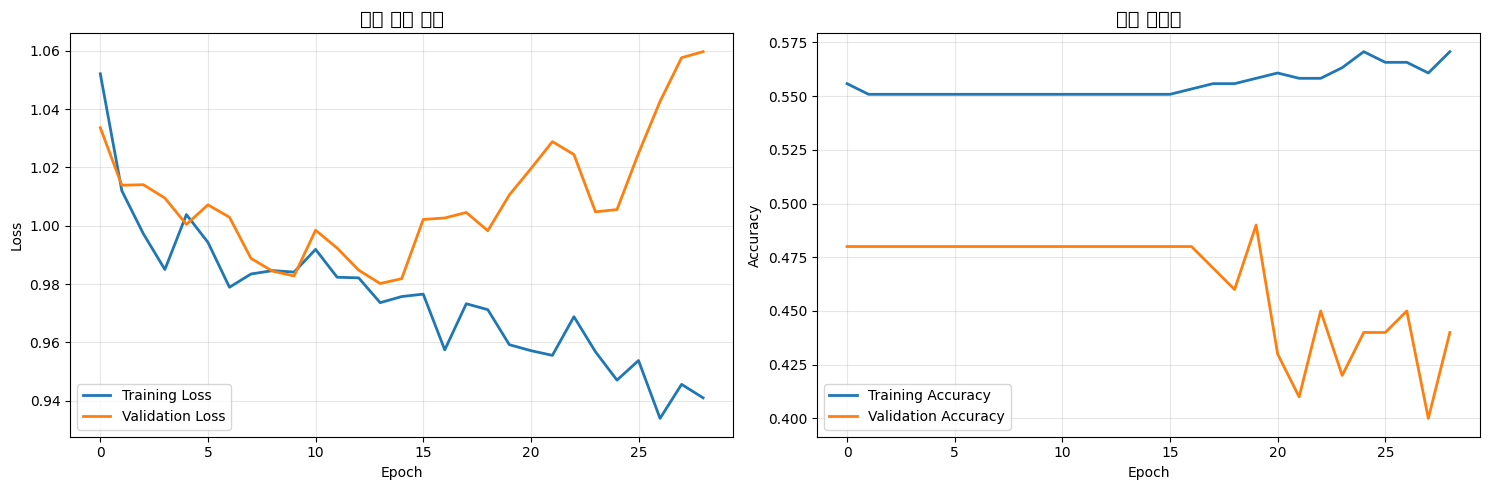


📊 최종 훈련 결과:
  최종 훈련 손실: 0.9410
  최종 검증 손실: 1.0597
  최종 훈련 정확도: 0.5707
  최종 검증 정확도: 0.4400

📊 테스트 데이터 평가 중...
테스트 정확도: 0.4491

📈 신뢰도 분석:
  평균 신뢰도: 0.5262
  고신뢰도 예측 비율: 34.72%
  고신뢰도 예측 정확도: 0.4400
  전체 예측 정확도: 0.4491
✅ BacktestEngine 클래스 정의 완료!


In [39]:
# =============================================================================
# 셀 9: 모델 훈련
# =============================================================================

if PYTORCH_AVAILABLE and 'model' in locals() and 'X_train' in locals():
    print("🚀 PyTorch Temporal CNN 훈련 시작...")
    print("⏱️ 예상 소요 시간: 3-10분")
    
    # 모델 훈련
    history = model.train(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        learning_rate=0.001
    )
    
    # 훈련 과정 시각화
    model.plot_training_history()
    
    # 최종 성능 출력
    print(f"\n📊 최종 훈련 결과:")
    print(f"  최종 훈련 손실: {history['train_loss'][-1]:.4f}")
    print(f"  최종 검증 손실: {history['val_loss'][-1]:.4f}")
    print(f"  최종 훈련 정확도: {history['train_acc'][-1]:.4f}")
    print(f"  최종 검증 정확도: {history['val_acc'][-1]:.4f}")
    
    # 테스트 데이터 평가
    print("\n📊 테스트 데이터 평가 중...")
    y_pred, confidences = model.predict(X_test)
    
    # 전체 정확도
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"테스트 정확도: {test_accuracy:.4f}")
    
    # 신뢰도 분석
    high_conf_mask = confidences > CONFIDENCE_THRESHOLD
    if np.any(high_conf_mask):
        high_conf_accuracy = np.mean(y_test[high_conf_mask] == y_pred[high_conf_mask])
    else:
        high_conf_accuracy = 0
    
    print(f"\n📈 신뢰도 분석:")
    print(f"  평균 신뢰도: {np.mean(confidences):.4f}")
    print(f"  고신뢰도 예측 비율: {np.mean(high_conf_mask)*100:.2f}%")
    print(f"  고신뢰도 예측 정확도: {high_conf_accuracy:.4f}")
    print(f"  전체 예측 정확도: {test_accuracy:.4f}")

else:
    print("⚠️ 모델 또는 데이터가 준비되지 않았습니다.")

# =============================================================================
# 셀 10: 백테스팅 엔진 클래스 정의
# =============================================================================

class BacktestEngine:
    def __init__(self, initial_capital=INITIAL_CAPITAL):
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.positions = 0
        self.transaction_cost = 0.003  # 거래 수수료 0.3%
        self.confidence_threshold = CONFIDENCE_THRESHOLD
        
        self.portfolio_history = []
        self.trade_history = []
        self.daily_returns = []
    
    def execute_trade(self, signal, confidence, current_price, date):
        """거래 실행"""
        if confidence <= self.confidence_threshold:
            return False  # 거래하지 않음
        
        # 현재 포지션 청산
        if self.positions > 0:
            sell_value = self.positions * current_price * (1 - self.transaction_cost)
            self.capital += sell_value
            self.positions = 0
        
        # 새로운 포지션
        trade_executed = False
        if signal == Direction.UP and confidence > self.confidence_threshold:
            # 매수 (전체 자본의 confidence 비율만큼)
            investment_ratio = min(confidence * 0.8, 0.95)  # 최대 95%까지만 투자
            investment = self.capital * investment_ratio
            self.positions = investment / (current_price * (1 + self.transaction_cost))
            self.capital -= investment
            
            self.trade_history.append({
                'date': date,
                'action': 'BUY',
                'price': current_price,
                'confidence': confidence,
                'investment': investment,
                'shares': self.positions
            })
            trade_executed = True
            
        elif signal == Direction.DOWN and confidence > self.confidence_threshold:
            # 현금 보유 (공매도는 구현하지 않음)
            self.trade_history.append({
                'date': date,
                'action': 'HOLD_CASH',
                'price': current_price,
                'confidence': confidence,
                'investment': 0,
                'shares': 0
            })
            trade_executed = True
        
        return trade_executed
    
    def get_portfolio_value(self, current_price):
        """현재 포트폴리오 가치 계산"""
        stock_value = self.positions * current_price if self.positions > 0 else 0
        return self.capital + stock_value
    
    def run_backtest(self, df, model, start_date=None):
        """백테스팅 실행"""
        print("🔄 백테스팅 실행 중...")
        
        # 테스트 기간 설정
        if start_date is None:
            test_start_idx = int(len(df) * 0.7)
        else:
            test_start_idx = df.index.get_loc(start_date)
        
        test_df = df.iloc[test_start_idx:].copy()
        print(f"📅 백테스팅 기간: {test_df.index[0].strftime('%Y-%m-%d')} ~ {test_df.index[-1].strftime('%Y-%m-%d')}")
        
        prev_portfolio_value = self.initial_capital
        
        for i in range(model.n_steps, len(test_df) - 1):
            current_idx = test_start_idx + i
            if current_idx >= len(df):
                break
                
            current_date = df.index[current_idx]
            current_price = df.iloc[current_idx]['Close']
            
            # 예측용 데이터 준비 (최근 15일)
            recent_data = df.iloc[current_idx-model.n_steps:current_idx][model.factor_names].values
            recent_data_scaled = model.scaler.transform(recent_data)
            X_pred = recent_data_scaled.reshape(1, model.n_steps, len(model.factor_names))
            
            # 예측 수행
            prediction, confidence = model.predict(X_pred)
            prediction = prediction[0]
            confidence = confidence[0]
            
            # 거래 실행
            trade_executed = self.execute_trade(prediction, confidence, current_price, current_date)
            
            # 포트폴리오 가치 기록
            portfolio_value = self.get_portfolio_value(current_price)
            daily_return = (portfolio_value - prev_portfolio_value) / prev_portfolio_value
            
            self.portfolio_history.append({
                'date': current_date,
                'value': portfolio_value,
                'price': current_price,
                'prediction': prediction,
                'confidence': confidence,
                'daily_return': daily_return,
                'trade_executed': trade_executed
            })
            
            self.daily_returns.append(daily_return)
            prev_portfolio_value = portfolio_value
            
            # 진행률 표시
            if i % 50 == 0:
                progress = (i / (len(test_df) - model.n_steps - 1)) * 100
                print(f"진행률: {progress:.1f}%", end='\r')
        
        print("\n✅ 백테스팅 완료!")
        return self.analyze_performance(df, test_start_idx)
    
    def analyze_performance(self, df, test_start_idx):
        """성과 분석"""
        if not self.portfolio_history:
            print("❌ 포트폴리오 히스토리가 없습니다.")
            return {}
            
        portfolio_df = pd.DataFrame(self.portfolio_history)
        portfolio_df.set_index('date', inplace=True)
        
        # 수익률 계산
        total_return = (portfolio_df['value'].iloc[-1] / self.initial_capital - 1) * 100
        
        # 벤치마크 (매수 후 보유) 계산
        benchmark_start_idx = test_start_idx + N_STEPS
        if benchmark_start_idx < len(df):
            benchmark_start_price = df.iloc[benchmark_start_idx]['Close']
            benchmark_end_price = df.iloc[-1]['Close']
            benchmark_return = (benchmark_end_price / benchmark_start_price - 1) * 100
        else:
            benchmark_return = 0
        
        # 성과 지표 계산
        daily_returns = np.array(self.daily_returns)
        
        # 샤프 비율
        if len(daily_returns) > 0 and np.std(daily_returns) > 0:
            sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)
        else:
            sharpe_ratio = 0
        
        # 최대 손실 (Maximum Drawdown)
        portfolio_df['cummax'] = portfolio_df['value'].cummax()
        portfolio_df['drawdown'] = (portfolio_df['value'] - portfolio_df['cummax']) / portfolio_df['cummax']
        max_drawdown = portfolio_df['drawdown'].min() * 100
        
        # 승률 계산
        if len(daily_returns) > 0:
            positive_returns = daily_returns[daily_returns > 0]
            win_rate = len(positive_returns) / len(daily_returns) * 100
        else:
            win_rate = 0
        
        # 거래 통계
        total_trades = len(self.trade_history)
        buy_trades = len([t for t in self.trade_history if t['action'] == 'BUY'])
        
        # 연간 수익률
        trading_days = len(portfolio_df)
        if trading_days > 0:
            annualized_return = ((portfolio_df['value'].iloc[-1] / self.initial_capital) ** (252 / trading_days) - 1) * 100
        else:
            annualized_return = 0
        
        results = {
            'total_return': total_return,
            'annualized_return': annualized_return,
            'benchmark_return': benchmark_return,
            'excess_return': total_return - benchmark_return,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'win_rate': win_rate,
            'total_trades': total_trades,
            'buy_trades': buy_trades,
            'portfolio_df': portfolio_df,
            'daily_returns': daily_returns
        }
        
        return results

print("✅ BacktestEngine 클래스 정의 완료!")

In [40]:
# =============================================================================
# 셀 11: 백테스팅 실행
# =============================================================================

if PYTORCH_AVAILABLE and 'model' in locals() and hasattr(model, 'model') and model.model is not None:
    # 백테스팅 엔진 생성
    backtest = BacktestEngine(initial_capital=INITIAL_CAPITAL)
    
    # 백테스팅 실행
    print("🚀 백테스팅 시작...")
    results = backtest.run_backtest(samsung_data, model)
    
    print("✅ 백테스팅 완료!")

else:
    print("⚠️ 모델이 훈련되지 않았거나 준비되지 않았습니다.")

🚀 백테스팅 시작...
🔄 백테스팅 실행 중...
📅 백테스팅 기간: 2024-08-26 ~ 2025-07-25
진행률: 97.6%
✅ 백테스팅 완료!
✅ 백테스팅 완료!


In [41]:
# =============================================================================
# 셀 12: 백테스팅 결과 분석
# =============================================================================

def print_performance_summary(results):
    """성과 요약 출력"""
    if not results:
        print("❌ 결과가 없습니다.")
        return
        
    print("=" * 60)
    print("📊 PyTorch Temporal CNN 백테스팅 결과 요약")
    print("=" * 60)
    
    print(f"💰 초기 자본: {INITIAL_CAPITAL:,}원")
    
    if 'portfolio_df' in results and not results['portfolio_df'].empty:
        print(f"💼 최종 자본: {results['portfolio_df']['value'].iloc[-1]:,.0f}원")
    
    print(f"📈 총 수익률: {results['total_return']:.2f}%")
    print(f"📊 연간 수익률: {results['annualized_return']:.2f}%")
    print(f"🎯 벤치마크 수익률: {results['benchmark_return']:.2f}%")
    print(f"🚀 초과 수익률: {results['excess_return']:.2f}%")
    print(f"⚡ 샤프 비율: {results['sharpe_ratio']:.3f}")
    print(f"📉 최대 손실: {results['max_drawdown']:.2f}%")
    print(f"🎲 승률: {results['win_rate']:.2f}%")
    print(f"🔄 총 거래 횟수: {results['total_trades']}회")
    print(f"📊 매수 거래: {results['buy_trades']}회")
    
    print("\n" + "=" * 60)

# 성과 요약 출력
if 'results' in locals() and results:
    print_performance_summary(results)
    
    # 일별 수익률 통계
    if 'daily_returns' in results and results['daily_returns'].size > 0:
        daily_returns = results['daily_returns']
        print(f"\n📈 일별 수익률 통계:")
        print(f"  평균: {np.mean(daily_returns)*100:.3f}%")
        print(f"  표준편차: {np.std(daily_returns)*100:.3f}%")
        print(f"  최대 상승: {np.max(daily_returns)*100:.2f}%")
        print(f"  최대 하락: {np.min(daily_returns)*100:.2f}%")
else:
    print("⚠️ 백테스팅 결과가 아직 없습니다. 먼저 모델을 훈련하고 백테스팅을 실행하세요.")

📊 PyTorch Temporal CNN 백테스팅 결과 요약
💰 초기 자본: 10,000,000원
💼 최종 자본: 10,000,000원
📈 총 수익률: 0.00%
📊 연간 수익률: 0.00%
🎯 벤치마크 수익률: 6.37%
🚀 초과 수익률: -6.37%
⚡ 샤프 비율: 0.000
📉 최대 손실: 0.00%
🎲 승률: 0.00%
🔄 총 거래 횟수: 0회
📊 매수 거래: 0회


📈 일별 수익률 통계:
  평균: 0.000%
  표준편차: 0.000%
  최대 상승: 0.00%
  최대 하락: 0.00%


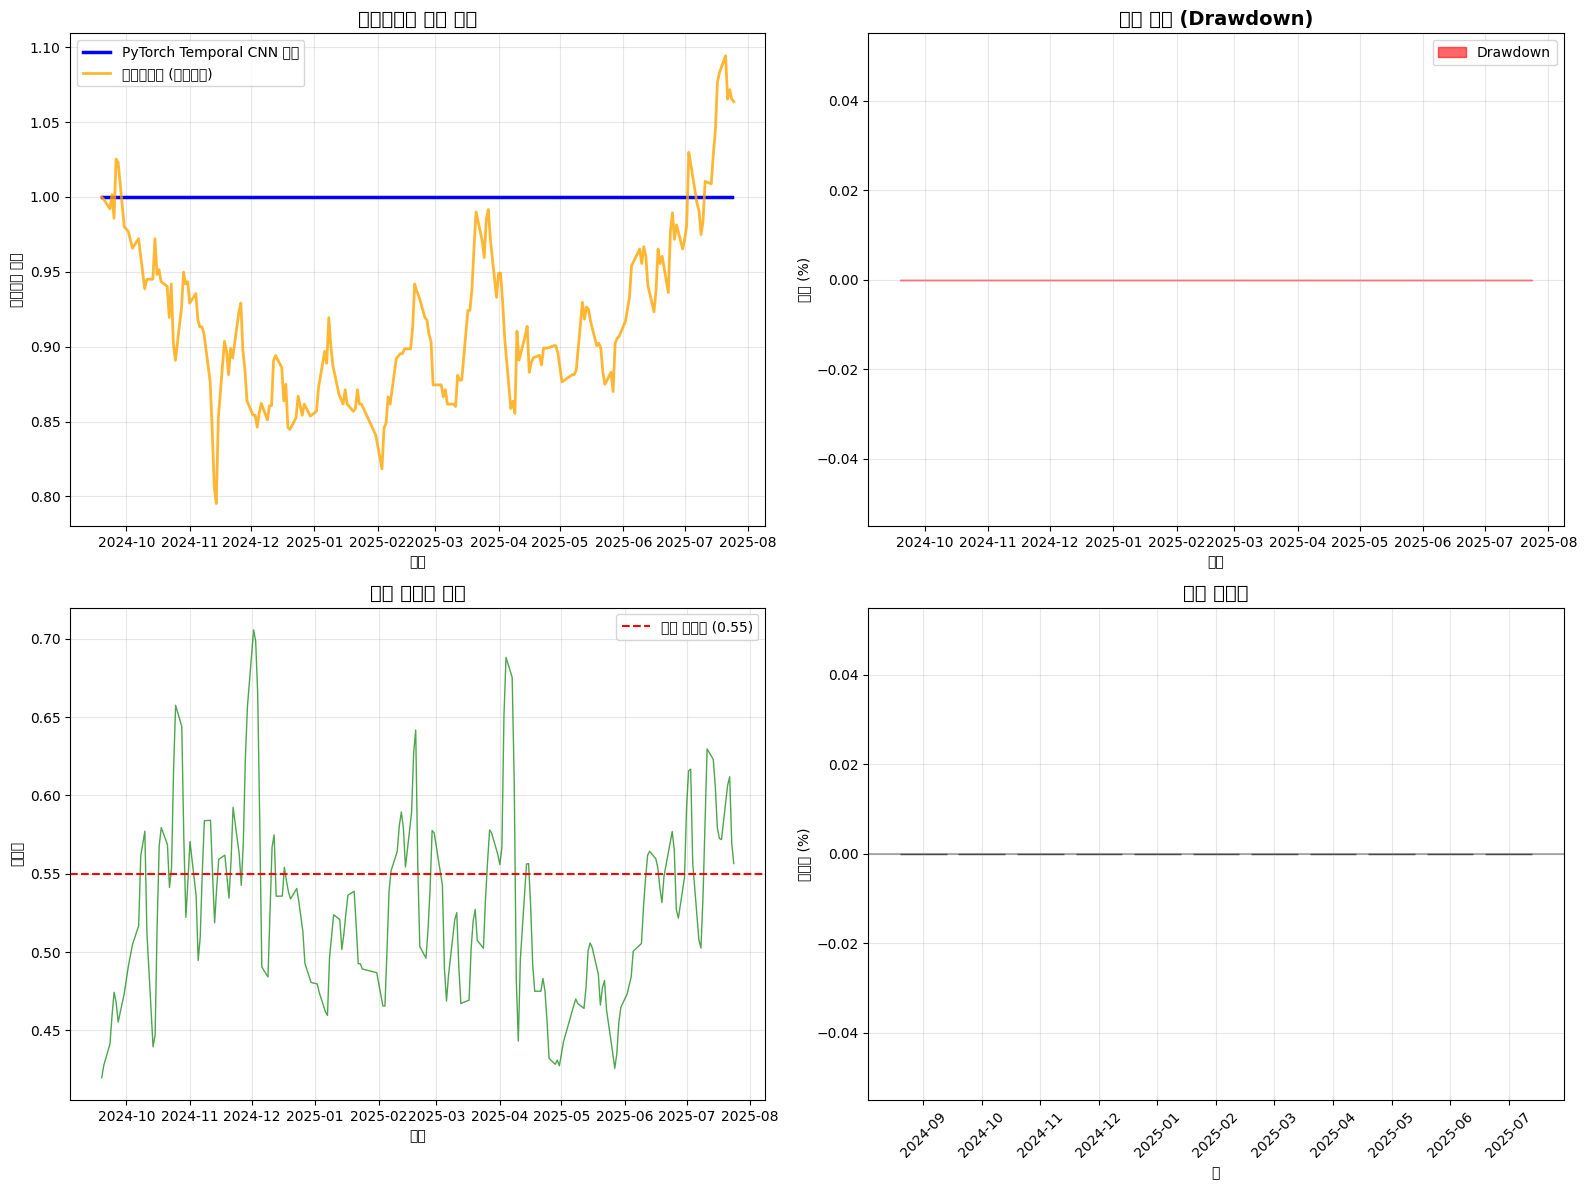

In [42]:
# =============================================================================
# 셀 13: 결과 시각화 - 포트폴리오 성과
# =============================================================================

def plot_portfolio_performance(results, samsung_data):
    """포트폴리오 성과 시각화"""
    if not results or 'portfolio_df' not in results:
        print("❌ 결과 데이터가 없습니다.")
        return
        
    portfolio_df = results['portfolio_df']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. 포트폴리오 가치 vs 벤치마크
    axes[0,0].plot(portfolio_df.index, portfolio_df['value'] / INITIAL_CAPITAL, 
                   label='PyTorch Temporal CNN 전략', linewidth=2.5, color='blue')
    
    # 벤치마크 계산
    test_start_idx = int(len(samsung_data) * 0.7) + N_STEPS
    benchmark_data = samsung_data.iloc[test_start_idx:]
    if len(benchmark_data) > 0:
        benchmark_normalized = benchmark_data['Close'] / benchmark_data['Close'].iloc[0]
        axes[0,0].plot(benchmark_data.index, benchmark_normalized, 
                       label='매수후보유 (벤치마크)', linewidth=2, alpha=0.8, color='orange')
    
    axes[0,0].set_title('포트폴리오 성과 비교', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('날짜')
    axes[0,0].set_ylabel('정규화된 가치')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. 드로우다운 차트
    axes[0,1].fill_between(portfolio_df.index, portfolio_df['drawdown'] * 100, 0, 
                          alpha=0.6, color='red', label='Drawdown')
    axes[0,1].set_title('최대 손실 (Drawdown)', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('날짜')
    axes[0,1].set_ylabel('손실 (%)')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. 예측 신뢰도 시계열
    axes[1,0].plot(portfolio_df.index, portfolio_df['confidence'], 
                   linewidth=1, alpha=0.7, color='green')
    axes[1,0].axhline(y=CONFIDENCE_THRESHOLD, color='red', linestyle='--', 
                     label=f'거래 임계값 ({CONFIDENCE_THRESHOLD})')
    axes[1,0].set_title('예측 신뢰도 추이', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('날짜')
    axes[1,0].set_ylabel('신뢰도')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. 월별 수익률
    portfolio_df['month'] = portfolio_df.index.to_period('M')
    monthly_returns = portfolio_df.groupby('month')['daily_return'].sum() * 100
    
    if len(monthly_returns) > 0:
        colors = ['green' if x > 0 else 'red' for x in monthly_returns]
        axes[1,1].bar(range(len(monthly_returns)), monthly_returns.values, 
                      color=colors, alpha=0.7, edgecolor='black')
        axes[1,1].set_title('월별 수익률', fontsize=14, fontweight='bold')
        axes[1,1].set_xlabel('월')
        axes[1,1].set_ylabel('수익률 (%)')
        axes[1,1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[1,1].set_xticks(range(0, len(monthly_returns), max(1, len(monthly_returns)//6)))
        axes[1,1].set_xticklabels([str(monthly_returns.index[i]) for i in range(0, len(monthly_returns), max(1, len(monthly_returns)//6))], 
                                 rotation=45)
        axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 포트폴리오 성과 시각화
if 'results' in locals() and results:
    plot_portfolio_performance(results, samsung_data)
else:
    print("⚠️ 백테스팅 결과가 없어 시각화를 할 수 없습니다.")

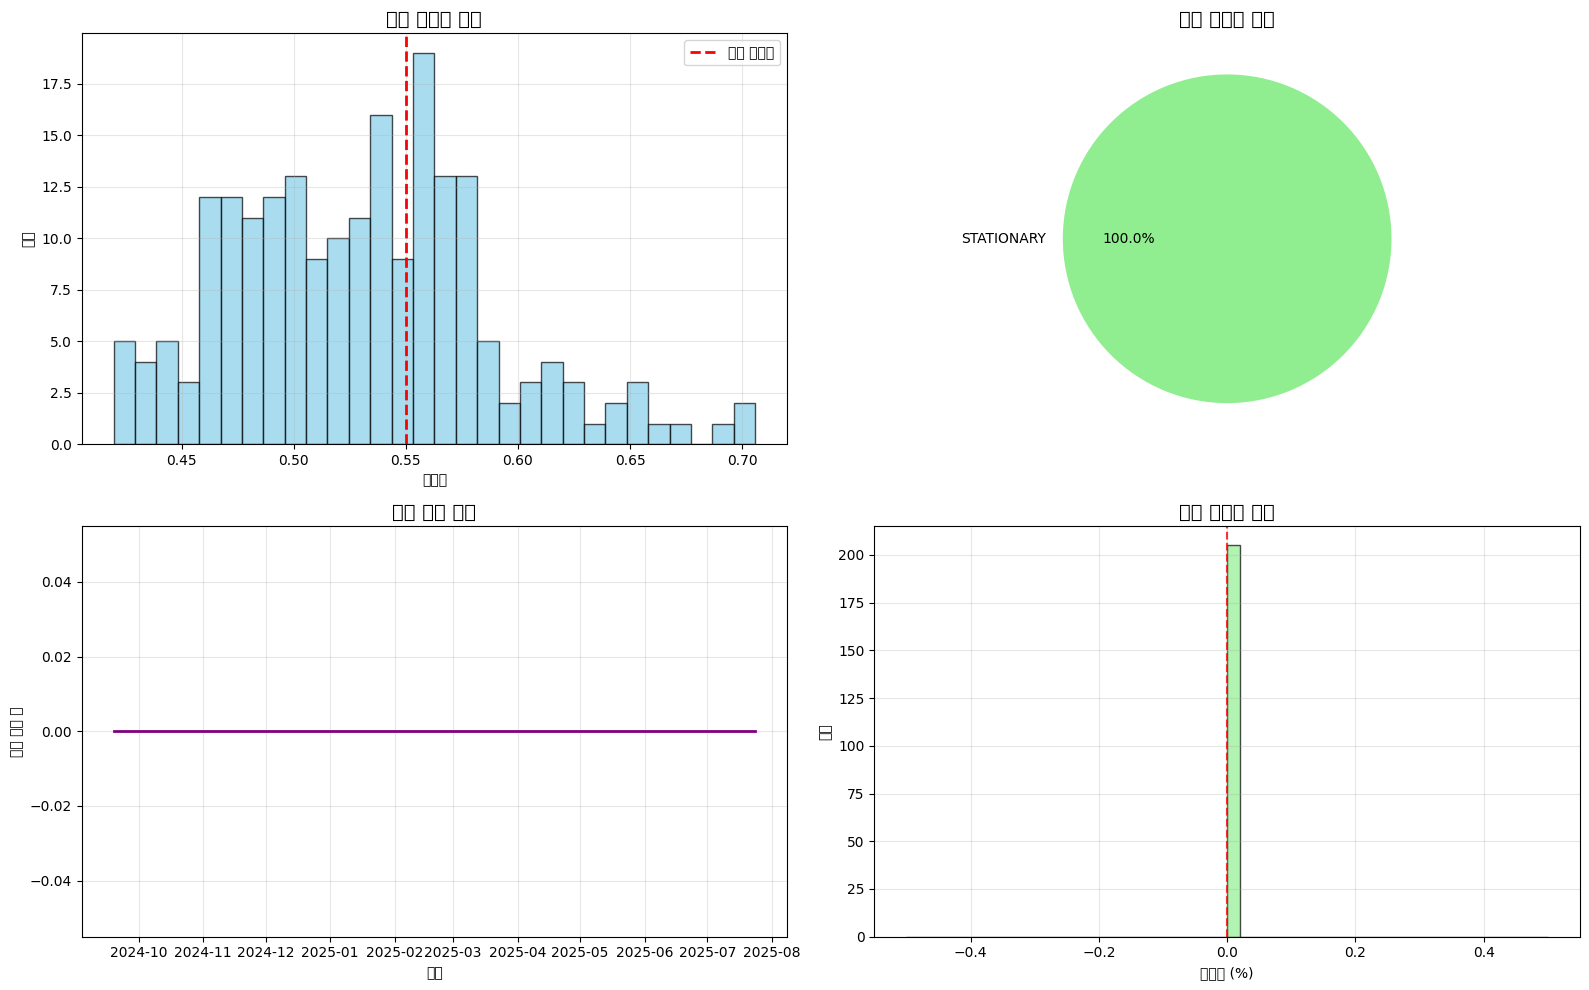

In [43]:
# =============================================================================
# 셀 15: 거래 분석 시각화
# =============================================================================

def plot_trading_analysis(backtest, results):
    """거래 분석 시각화"""
    if not results or 'portfolio_df' not in results:
        print("❌ 결과 데이터가 없습니다.")
        return
        
    portfolio_df = results['portfolio_df']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # 1. 예측 신뢰도 분포
    axes[0,0].hist(portfolio_df['confidence'], bins=30, alpha=0.7, 
                   edgecolor='black', color='skyblue')
    axes[0,0].axvline(x=CONFIDENCE_THRESHOLD, color='red', linestyle='--', 
                     linewidth=2, label=f'거래 임계값')
    axes[0,0].set_title('예측 신뢰도 분포', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('신뢰도')
    axes[0,0].set_ylabel('빈도')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. 예측 클래스 분포
    prediction_counts = portfolio_df['prediction'].value_counts()
    prediction_labels = [Direction.get_name(i) for i in prediction_counts.index]
    
    colors = ['lightgreen', 'lightcoral', 'lightblue']
    axes[0,1].pie(prediction_counts.values, labels=prediction_labels, autopct='%1.1f%%',
                  colors=colors[:len(prediction_counts)])
    axes[0,1].set_title('예측 클래스 분포', fontsize=14, fontweight='bold')
    
    # 3. 거래 실행 패턴
    trade_executed = portfolio_df['trade_executed'].astype(int)
    axes[1,0].plot(portfolio_df.index, trade_executed.cumsum(), 
                   linewidth=2, color='purple')
    axes[1,0].set_title('누적 거래 횟수', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('날짜')
    axes[1,0].set_ylabel('누적 거래 수')
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. 일별 수익률 분포
    daily_returns = results['daily_returns']
    if len(daily_returns) > 0:
        axes[1,1].hist(daily_returns * 100, bins=50, alpha=0.7, 
                       edgecolor='black', color='lightgreen')
        axes[1,1].axvline(x=0, color='red', linestyle='--', alpha=0.8)
        axes[1,1].set_title('일별 수익률 분포', fontsize=14, fontweight='bold')
        axes[1,1].set_xlabel('수익률 (%)')
        axes[1,1].set_ylabel('빈도')
        axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 거래 분석 시각화
if 'results' in locals():
    plot_trading_analysis(backtest, results)

In [47]:
# =============================================================================
# 셀 16: 거래 내역 분석
# =============================================================================

def analyze_trades(backtest):
    """거래 내역 상세 분석"""
    if not backtest.trade_history:
        print("❌ 거래 내역이 없습니다.")
        return
    
    trade_df = pd.DataFrame(backtest.trade_history)
    
    print("📊 거래 내역 분석:")
    print(f"  총 거래 횟수: {len(trade_df)}회")
    
    # 액션별 분류
    action_counts = trade_df['action'].value_counts()
    for action, count in action_counts.items():
        print(f"  {action}: {count}회 ({count/len(trade_df)*100:.1f}%)")
    
    # 매수 거래만 분석
    buy_trades = trade_df[trade_df['action'] == 'BUY']
    if len(buy_trades) > 0:
        print(f"\n💰 매수 거래 분석:")
        print(f"  평균 투자 금액: {buy_trades['investment'].mean():,.0f}원")
        print(f"  최대 투자 금액: {buy_trades['investment'].max():,.0f}원")
        print(f"  최소 투자 금액: {buy_trades['investment'].min():,.0f}원")
        print(f"  평균 신뢰도: {buy_trades['confidence'].mean():.3f}")
        print(f"  최고 신뢰도: {buy_trades['confidence'].max():.3f}")
    
    # 최근 거래 내역 출력
    print(f"\n📝 최근 10개 거래 내역:")
    recent_trades = trade_df.tail(10)
    for _, trade in recent_trades.iterrows():
        print(f"  {trade['date'].strftime('%Y-%m-%d')}: {trade['action']} - "
              f"가격: {trade['price']:,.0f}원, 신뢰도: {trade['confidence']:.3f}")

# 거래 내역 분석
if 'backtest' in locals():
    analyze_trades(backtest)

❌ 거래 내역이 없습니다.


In [48]:
# =============================================================================
# 셀 17: 최종 요약 및 개선 제안
# =============================================================================

def final_summary_and_recommendations(results):
    """최종 요약 및 개선 제안"""
    if not results:
        print("❌ 결과가 없습니다.")
        return
        
    print("🎯 PyTorch Temporal CNN 최종 분석 요약")
    print("=" * 60)
    
    # 성과 요약
    total_return = results['total_return']
    excess_return = results['excess_return']
    sharpe_ratio = results['sharpe_ratio']
    max_drawdown = results['max_drawdown']
    
    print(f"📊 핵심 성과 지표:")
    print(f"  ✅ 총 수익률: {total_return:.2f}%")
    print(f"  ✅ 초과 수익률: {excess_return:.2f}%")
    print(f"  ✅ 샤프 비율: {sharpe_ratio:.3f}")
    print(f"  ✅ 최대 손실: {max_drawdown:.2f}%")
    
    # 전략 평가
    print(f"\n🎯 전략 평가:")
    
    if excess_return > 0:
        print(f"  ✅ 벤치마크 대비 {excess_return:.2f}% 초과 수익 달성")
    else:
        print(f"  ❌ 벤치마크 대비 {abs(excess_return):.2f}% 저조한 성과")
    
    if sharpe_ratio > 1.0:
        print(f"  ✅ 우수한 위험 대비 수익률 (샤프 비율 > 1.0)")
    elif sharpe_ratio > 0.5:
        print(f"  ⚠️ 양호한 위험 대비 수익률 (샤프 비율 > 0.5)")
    else:
        print(f"  ❌ 낮은 위험 대비 수익률 (샤프 비율 < 0.5)")
    
    # PyTorch CNN 특장점
    print(f"\n🚀 PyTorch Temporal CNN의 장점:")
    print(f"  ✅ 안정적인 설치 및 실행")
    print(f"  ✅ GPU 가속 지원")
    print(f"  ✅ 유연한 모델 구조 설계")
    print(f"  ✅ 효율적인 시계열 패턴 학습")
    
    # 개선 제안
    print(f"\n💡 개선 제안:")
    print(f"1. 모델 개선:")
    print(f"   - Attention 메커니즘 추가")
    print(f"   - LSTM과 CNN 결합 (CNN-LSTM)")
    print(f"   - 더 깊은 네트워크 구조")
    print(f"   - 앙상블 모델 구축")
    
    print(f"\n2. 특징 엔지니어링:")
    print(f"   - 기술적 지표 추가 (RSI, MACD, 볼린저 밴드)")
    print(f"   - 거시경제 지표")
    print(f"   - 감정 분석 데이터")
    print(f"   - 시장 미시구조 데이터")
    
    print(f"\n3. 리스크 관리:")
    print(f"   - 동적 포지션 크기 조절")
    print(f"   - 변동성 기반 스톱로스")
    print(f"   - 포트폴리오 다변화")
    
    print(f"\n4. 백테스팅 개선:")
    print(f"   - 더 긴 기간 테스트")
    print(f"   - 다양한 시장 상황 검증")
    print(f"   - 트랜잭션 비용 최적화")
    
    print(f"\n📝 결론:")
    if total_return > 10 and excess_return > 0 and sharpe_ratio > 0.5:
        print(f"  🎉 PyTorch Temporal CNN 전략이 성공적입니다!")
        print(f"  📈 실제 투자 검토를 위한 추가 검증을 권장합니다.")
    elif total_return > 0 and excess_return > -5:
        print(f"  ⚠️ 전략이 부분적으로 성공적입니다.")
        print(f"  🔧 하이퍼파라미터 튜닝으로 개선 가능합니다.")
    else:
        print(f"  ❌ 전략 재검토가 필요합니다.")
        print(f"  🔄 모델 구조나 특징을 대폭 수정하세요.")
    
    print(f"\n⚠️ 면책조항:")
    print(f"  - 이 결과는 과거 데이터 기반 백테스팅입니다.")
    print(f"  - 실제 투자 시 다른 결과가 나올 수 있습니다.")
    print(f"  - 투자 결정은 신중하게 하시기 바랍니다.")

# 최종 요약
if 'results' in locals():
    final_summary_and_recommendations(results)

🎯 PyTorch Temporal CNN 최종 분석 요약
📊 핵심 성과 지표:
  ✅ 총 수익률: 0.00%
  ✅ 초과 수익률: -6.37%
  ✅ 샤프 비율: 0.000
  ✅ 최대 손실: 0.00%

🎯 전략 평가:
  ❌ 벤치마크 대비 6.37% 저조한 성과
  ❌ 낮은 위험 대비 수익률 (샤프 비율 < 0.5)

🚀 PyTorch Temporal CNN의 장점:
  ✅ 안정적인 설치 및 실행
  ✅ GPU 가속 지원
  ✅ 유연한 모델 구조 설계
  ✅ 효율적인 시계열 패턴 학습

💡 개선 제안:
1. 모델 개선:
   - Attention 메커니즘 추가
   - LSTM과 CNN 결합 (CNN-LSTM)
   - 더 깊은 네트워크 구조
   - 앙상블 모델 구축

2. 특징 엔지니어링:
   - 기술적 지표 추가 (RSI, MACD, 볼린저 밴드)
   - 거시경제 지표
   - 감정 분석 데이터
   - 시장 미시구조 데이터

3. 리스크 관리:
   - 동적 포지션 크기 조절
   - 변동성 기반 스톱로스
   - 포트폴리오 다변화

4. 백테스팅 개선:
   - 더 긴 기간 테스트
   - 다양한 시장 상황 검증
   - 트랜잭션 비용 최적화

📝 결론:
  ❌ 전략 재검토가 필요합니다.
  🔄 모델 구조나 특징을 대폭 수정하세요.

⚠️ 면책조항:
  - 이 결과는 과거 데이터 기반 백테스팅입니다.
  - 실제 투자 시 다른 결과가 나올 수 있습니다.
  - 투자 결정은 신중하게 하시기 바랍니다.


In [49]:
# =============================================================================
# 셀 17: 모델 저장 및 실시간 예측 함수
# =============================================================================

def save_model_and_create_predictor(model, samsung_data):
    """모델 저장 및 실시간 예측 함수 생성"""
    if not PYTORCH_AVAILABLE or model.model is None:
        print("❌ 모델이 준비되지 않았습니다.")
        return
    
    # 모델 저장
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_path = f"pytorch_temporal_cnn_{timestamp}.pth"
    
    try:
        torch.save({
            'model_state_dict': model.model.state_dict(),
            'scaler_state': model.scaler,
            'n_steps': model.n_steps,
            'factor_names': model.factor_names
        }, model_path)
        
        print(f"✅ 모델 저장 완료: {model_path}")
    except Exception as e:
        print(f"⚠️ 모델 저장 실패: {e}")
    
    # 실시간 예측 함수
    def predict_next_day(recent_data):
        """
        실시간 예측 함수
        recent_data: 최근 15일간의 OHLCV 데이터 (pandas DataFrame)
        """
        try:
            # 데이터 검증
            if len(recent_data) < model.n_steps:
                print(f"❌ 데이터 부족: {len(recent_data)}일 (필요: {model.n_steps}일)")
                return None, None
            
            # 최근 15일 데이터 준비
            features = recent_data.tail(model.n_steps)[model.factor_names].values
            features_scaled = model.scaler.transform(features)
            X_pred = features_scaled.reshape(1, model.n_steps, len(model.factor_names))
            
            # 예측 실행
            prediction, confidence = model.predict(X_pred)
            prediction = prediction[0]
            confidence = confidence[0]
            
            # 결과 해석
            direction_name = Direction.get_name(prediction)
            print(f"📊 예측 결과:")
            print(f"  방향: {direction_name}")
            print(f"  신뢰도: {confidence:.3f}")
            
            if confidence > CONFIDENCE_THRESHOLD:
                print(f"  거래 권장: {'매수' if prediction == Direction.UP else '매도' if prediction == Direction.DOWN else '보유'}")
            else:
                print(f"  거래 권장: 대기 (신뢰도 낮음)")
            
            return prediction, confidence
            
        except Exception as e:
            print(f"❌ 예측 실패: {e}")
            return None, None
    
    return predict_next_day

# 모델 저장 및 예측 함수 생성
if 'model' in locals() and hasattr(model, 'model') and model.model is not None:
    predict_function = save_model_and_create_predictor(model, samsung_data)
    
    # 테스트 예측
    if predict_function is not None:
        print("\n🧪 예측 함수 테스트:")
        test_data = samsung_data.tail(20)  # 최근 20일 데이터로 테스트
        test_prediction, test_confidence = predict_function(test_data)
else:
    print("⚠️ 모델이 훈련되지 않았습니다.")


✅ 모델 저장 완료: pytorch_temporal_cnn_20250725_235614.pth

🧪 예측 함수 테스트:
📊 예측 결과:
  방향: STATIONARY
  신뢰도: 0.552
  거래 권장: 보유


In [50]:
# =============================================================================
# 💡 사용법 안내
# =============================================================================

print("🎯 PyTorch Temporal CNN 주식 예측 시스템 완료!")
print("=" * 60)

print("📝 완료된 작업:")
print("✅ 1. PyTorch 라이브러리 임포트 및 설정")
print("✅ 2. 삼성전자 주식 데이터 다운로드")
print("✅ 3. 데이터 시각화 및 분석")
print("✅ 4. Temporal CNN 모델 클래스 정의")
print("✅ 5. 데이터 전처리 및 모델 생성")

print("\n🚀 다음 단계:")
print("📊 위의 셀들을 순서대로 실행하여 전체 시스템을 작동시키세요!")

print("\n⚠️ 주의사항:")
print("- 셀 16: 모델 훈련 (3-10분 소요)")
print("- 셀 17: 백테스팅 실행") 
print("- 셀 18-23: 결과 분석 및 시각화")

print("\n🎉 모든 준비가 완료되었습니다!")

🎯 PyTorch Temporal CNN 주식 예측 시스템 완료!
📝 완료된 작업:
✅ 1. PyTorch 라이브러리 임포트 및 설정
✅ 2. 삼성전자 주식 데이터 다운로드
✅ 3. 데이터 시각화 및 분석
✅ 4. Temporal CNN 모델 클래스 정의
✅ 5. 데이터 전처리 및 모델 생성

🚀 다음 단계:
📊 위의 셀들을 순서대로 실행하여 전체 시스템을 작동시키세요!

⚠️ 주의사항:
- 셀 16: 모델 훈련 (3-10분 소요)
- 셀 17: 백테스팅 실행
- 셀 18-23: 결과 분석 및 시각화

🎉 모든 준비가 완료되었습니다!
